In [2]:
## import libraries
from xmitgcm import open_mdsdataset
from datetime import datetime
import time as t
import numpy as np
import xarray as xr
import scipy.interpolate as sci
from scipy.interpolate import griddata
import math
import os
import xgcm
from matplotlib import pyplot as plt

import seawater as sw
import gsw
%matplotlib inline

import xinvert
import dask
import numba
import netCDF4

### divQ of two area

In [26]:
FQvec_SCE=xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_xinvert/c2_1ydivQ.nc').__xarray_dataarray_variable__
FQvec_SAE=xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_xinvert/a2_1ydivQ.nc').__xarray_dataarray_variable__
FQvec_ECE=xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_xinvert/c2_1ydivQ.nc').__xarray_dataarray_variable__
FQvec_EAE=xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_xinvert/a2_1ydivQ.nc').__xarray_dataarray_variable__

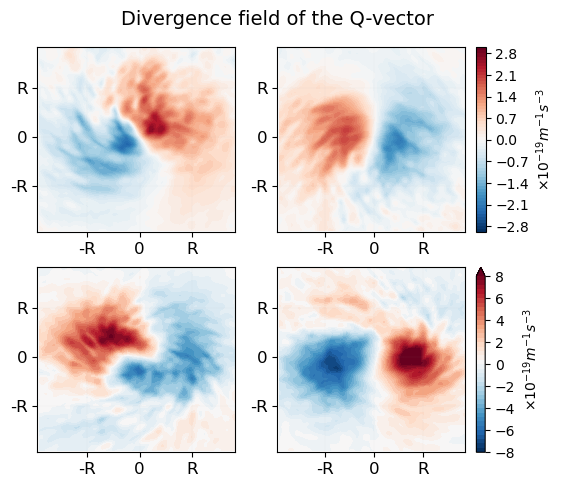

In [30]:
######## 画两个区域的 divQ ########
lev1=np.linspace(-3,3,61)
lev2=np.linspace(-8,8,41)

fig = plt.figure(figsize=(6, 5))
# 子图大小位置
pos1=[0.1,0.535,0.33,0.37] #左,下,长度,高度
pos2=[0.5,0.535,0.39,0.37]
pos3=[0.1,0.095,0.33,0.37]
pos4=[0.5,0.095,0.39,0.37]

ax1 = plt.axes(pos1)
(FQvec_SCE[8,2:98,2:98]*1e19).plot.contourf(cmap='RdBu_r', levels=lev1, add_colorbar=False)
ax1.set_ylabel('', fontsize=12) #设置 y 轴
ax1.set_yticks(np.linspace(-2,2,5))
ax1.set_yticklabels(('-2R','-R','0','R','2R'),fontsize=12)
plt.ylim([-1.96,1.84])
ax1.set_xlabel('', fontsize=12)
ax1.set_xticks(np.linspace(-2,2,5)) #[-1.96,-1,0,1,1.84]
ax1.set_xticklabels(('-2R','-R','0','R','2R'), fontsize=12)
plt.xlim([-1.96,1.84])
ax1.grid(True, linestyle='--', linewidth='0.1', alpha=0.5) #添加网格
# ax1.legend(loc='upper right', fontsize=10) #添加图例
ax1.set_title('', fontsize=12 ,fontweight='500') #设置标题

ax2 = plt.axes(pos2)
(FQvec_SAE[8,2:98,2:98]*1e19).plot.contourf(cmap='RdBu_r', levels=lev1, cbar_kwargs=dict(label=r'$ \times 10^{-19}  m^{-1}s^{-3}$'))# add_colorbar=False)
ax2.set_ylabel('', fontsize=12) #设置 y 轴
ax2.set_yticks(np.linspace(-2,2,5))
ax2.set_yticklabels(('-2R','-R','0','R','2R'),fontsize=12)
plt.ylim([-1.96,1.84])
ax2.set_xlabel('', fontsize=12)
ax2.set_xticks(np.linspace(-2,2,5))
ax2.set_xticklabels(('-2R','-R','0','R','2R'), fontsize=12)
plt.xlim([-1.96,1.84])
ax2.grid(True, linestyle='--', linewidth='0.1', alpha=0.5) #添加网格
# ax2.legend(loc='upper right', fontsize=10) #添加图例
ax2.set_title('', fontsize=12 ,fontweight='500') #设置标题


ax3 = plt.axes(pos3)
(FQvec_ECE[8,2:98,2:98]*1e19).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False)
ax3.set_ylabel('', fontsize=12) #设置 y 轴
ax3.set_yticks(np.linspace(-2,2,5))
ax3.set_yticklabels(('-2R','-R','0','R','2R'),fontsize=12)
plt.ylim([-1.96,1.84])
ax3.set_xlabel('', fontsize=12)
ax3.set_xticks(np.linspace(-2,2,5))
ax3.set_xticklabels(('-2R','-R','0','R','2R'), fontsize=12)
plt.xlim([-1.96,1.84])
ax3.grid(True, linestyle='--', linewidth='0.1', alpha=0.5) #添加网格
# ax3.legend(loc='upper right', fontsize=10) #添加图例
ax3.set_title('', fontsize=12 ,fontweight='500') #设置标题

ax4 = plt.axes(pos4)
(FQvec_EAE[8,2:98,2:98]*1e19).plot.contourf(cmap='RdBu_r', levels=lev2, cbar_kwargs=dict(label=r'$ \times 10^{-19}  m^{-1}s^{-3}$'))
ax4.set_ylabel('', fontsize=12) #设置 y 轴
ax4.set_yticks(np.linspace(-2,2,5))
ax4.set_yticklabels(('-2R','-R','0','R','2R'),fontsize=12)
plt.ylim([-1.96,1.84])
ax4.set_xlabel('', fontsize=12)
ax4.set_xticks(np.linspace(-2,2,5))
ax4.set_xticklabels(('-2R','-R','0','R','2R'), fontsize=12)
plt.xlim([-1.96,1.84])
ax4.grid(True, linestyle='--', linewidth='0.1', alpha=0.5) #添加网格
# ax4.legend(loc='upper right', fontsize=10) #添加图例
ax4.set_title('', fontsize=12 ,fontweight='500') #设置标题

#添加整体标题
plt.suptitle('Divergence field of the Q-vector', fontsize=14, fontweight='500')

# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig8.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=300)
# # plt.close()

## 1. subtropical dipole

In [13]:
from xinvert import FiniteDiff
fd = FiniteDiff({'X':'XC', 'Y':'YC', 'Z':'Z'},
                BCs={'X':('extend','extend'),
                     'Y':('extend','extend'),
                     'Z':('extend','extend')}, fill=0, coords='lat-lon')

In [18]:
#########  sub双核  ##########
area='sub' #sub/frt

var = '1y' #1y/clim/anom
file_paths = {
    '1y': {
        'sce_u': '/data3/home/zhangrd/data/compoed_sub_variables/c2_1yu.nc',
        'sce_v': '/data3/home/zhangrd/data/compoed_sub_variables/c2_1yv.nc',
        'sce_w': '/data3/home/zhangrd/data/compoed_sub_variables/c2_1yw.nc',
        'sce_t': '/data3/home/zhangrd/data/compoed_sub_variables/c2_1yt.nc',
        'sce_e': '/data3/home/zhangrd/data/compoed_sub_variables/c2_1ye.nc',
        'sae_u': '/data3/home/zhangrd/data/compoed_sub_variables/a2_1yu.nc',
        'sae_v': '/data3/home/zhangrd/data/compoed_sub_variables/a2_1yv.nc',
        'sae_w': '/data3/home/zhangrd/data/compoed_sub_variables/a2_1yw.nc',
        'sae_t': '/data3/home/zhangrd/data/compoed_sub_variables/a2_1yt.nc',
        'sae_e': '/data3/home/zhangrd/data/compoed_sub_variables/a2_1ye.nc',},
    'clim': {
        'sce_u': '/data3/home/zhangrd/data/compoed_sub_variables/c2_climu.nc',
        'sce_v': '/data3/home/zhangrd/data/compoed_sub_variables/c2_climv.nc',
        'sce_w': '/data3/home/zhangrd/data/compoed_sub_variables/c2_climw.nc',
        'sce_t': '/data3/home/zhangrd/data/compoed_sub_variables/c2_climt.nc',
        'sce_e': '/data3/home/zhangrd/data/compoed_sub_variables/c2_clime.nc',
        'sae_u': '/data3/home/zhangrd/data/compoed_sub_variables/a2_climu.nc',
        'sae_v': '/data3/home/zhangrd/data/compoed_sub_variables/a2_climv.nc',
        'sae_w': '/data3/home/zhangrd/data/compoed_sub_variables/a2_climw.nc',
        'sae_t': '/data3/home/zhangrd/data/compoed_sub_variables/a2_climt.nc',
        'sae_e': '/data3/home/zhangrd/data/compoed_sub_variables/a2_clime.nc',},
    'anom': {
        'sce_u': '/data3/home/zhangrd/data/compoed_sub_variables/c2_ua.nc',
        'sce_v': '/data3/home/zhangrd/data/compoed_sub_variables/c2_va.nc',
        'sce_w': '/data3/home/zhangrd/data/compoed_sub_variables/c2_wa.nc',
        'sce_t': '/data3/home/zhangrd/data/compoed_sub_variables/c2_ta.nc',
        'sce_e': '/data3/home/zhangrd/data/compoed_sub_variables/c2_ea.nc',
        'sae_u': '/data3/home/zhangrd/data/compoed_sub_variables/a2_ua.nc',
        'sae_v': '/data3/home/zhangrd/data/compoed_sub_variables/a2_va.nc',
        'sae_w': '/data3/home/zhangrd/data/compoed_sub_variables/a2_wa.nc',
        'sae_t': '/data3/home/zhangrd/data/compoed_sub_variables/a2_ta.nc',
        'sae_e': '/data3/home/zhangrd/data/compoed_sub_variables/a2_ea.nc',},
}

if var not in file_paths:
    raise ValueError(f'invalid var: {var}')

paths = file_paths[var]
SCE_u = xr.open_dataset(paths['sce_u']).UVEL
SCE_v = xr.open_dataset(paths['sce_v']).VVEL
SCE_w = xr.open_dataset(paths['sce_w']).WVEL
SCE_t = xr.open_dataset(paths['sce_t']).THETA
SCE_e = xr.open_dataset(paths['sce_e']).ETAN
SAE_u = xr.open_dataset(paths['sae_u']).UVEL
SAE_v = xr.open_dataset(paths['sae_v']).VVEL
SAE_w = xr.open_dataset(paths['sae_w']).WVEL
SAE_t = xr.open_dataset(paths['sae_t']).THETA
SAE_e = xr.open_dataset(paths['sae_e']).ETAN

# 修改SCE坐标
new_coord = np.linspace(15, 19, 101)#生成新的坐标值 (替换原有坐标)
lev=np.arange(-5,-1055,-50)
SCE_u = SCE_u.interp(Z=lev)
SCE_v = SCE_v.interp(Z=lev)
SCE_w = SCE_w.interp(Zl=lev)
SCE_t = SCE_t.interp(Z=lev)
SCE_u=SCE_u.rename({'XG': 'XC'})
SCE_v=SCE_v.rename({'YG': 'YC'})
# SCE_u = SCE_u.assign_coords(YC=new_coord, XC=new_coord)
# SCE_v = SCE_v.assign_coords(YC=new_coord, XC=new_coord)
# SCE_w = SCE_w.assign_coords(YC=new_coord, XC=new_coord)
# SCE_t = SCE_t.assign_coords(YC=new_coord, XC=new_coord)
# SCE_e = SCE_e.assign_coords(YC=new_coord, XC=new_coord)

# 修改SAE坐标
SAE_u = SAE_u.interp(Z=lev)
SAE_v = SAE_v.interp(Z=lev)
SAE_w = SAE_w.interp(Zl=lev)
SAE_t = SAE_t.interp(Z=lev)
SAE_u=SAE_u.rename({'XG': 'XC'})
SAE_v=SAE_v.rename({'YG': 'YC'})
# SAE_u = SAE_u.assign_coords(YC=new_coord, XC=new_coord)
# SAE_v = SAE_v.assign_coords(YC=new_coord, XC=new_coord)
# SAE_w = SAE_w.assign_coords(YC=new_coord, XC=new_coord)
# SAE_t = SAE_t.assign_coords(YC=new_coord, XC=new_coord)
# SAE_e = SAE_e.assign_coords(YC=new_coord, XC=new_coord)
# np.isnan(SCE_w.data).sum() #10201

In [19]:
%%time
g = 9.81
rho0 = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4 # degrees^-1
def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + rho0
    return rho

SCE_rho  = linear_rho(35, SCE_t, sref, tref)
SAE_rho  = linear_rho(35, SAE_t, sref, tref)
# sigma = linear_rho(35, temp, sref, tref) - 1000 # sigma is " rho' "

# g = 9.81  # unit：m/s^2
# rho0 = 999.8  # 海水的平均密度，模式输出rhoRef为999.8，unit：kg/m^3
# sref = 35 # 绝对盐度为35, unit: g/kg
# h = xr.DataArray(-lev, dims=['Z'], coords={'Z':lev}).broadcast_like(SCE_t)  # 自动扩展到相同维度
# ### SCE
# SCE_pref = rho0 * g * (h + SCE_e) # 计算静力近似的压力场 pref 以便进一步计算rho,pref只与垂直维度Z相关
# SCE_CT = gsw.CT_from_pt(sref, SCE_t) # 由位温计算保守温度CT（Conservative Temperature）
# SCE_rho= gsw.rho(sref,SCE_CT,SCE_pref/1e4) # p_ref/1e4：帕转换为分巴, unit:dbar. (absolute pressure minus 10.1325 dbar)
# ### SAE
# SAE_pref = rho0 * g * (h + SAE_e)
# SAE_CT = gsw.CT_from_pt(sref, SAE_t)
# SAE_rho= gsw.rho(sref,SAE_CT,SAE_pref/1e4)


SCE_b  = SCE_rho * (-g/rho0)
SAE_b  = SAE_rho * (-g/rho0)
omg = 2*math.pi/(86400) # unit: rad/s
# f  = 2*omg*np.sin(np.deg2rad(dipole_t.YC))
SCE_N2 = SCE_b.mean(['YC','XC']).load().differentiate('Z').load()
SAE_N2 = SAE_b.mean(['YC','XC']).load().differentiate('Z').load()

CPU times: user 15.3 ms, sys: 168 µs, total: 15.5 ms
Wall time: 12.6 ms


In [ ]:
%%time
########## traditional form of forcings ##########
# SCE_bx, SCE_by = fd.grad(SCE_b, ['X', 'Y'])
# SAE_bx, SAE_by = fd.grad(SAE_b, ['X', 'Y'])
# SCE_zx, SCE_zy = fd.grad(fd.curl(SCE_u, SCE_u), ['X', 'Y'])
# SAE_zx, SAE_zy = fd.grad(fd.curl(SAE_u, SAE_u), ['X', 'Y'])

# SCE_adv_b = SCE_u*SCE_bx + SCE_v*SCE_by
# SCE_adv_z = SCE_u*SCE_zx + SCE_v*SCE_zy
# SAE_adv_b = SAE_u*SAE_bx + SAE_v*SAE_by
# SAE_adv_z = SAE_u*SAE_zx + SAE_v*SAE_zy

# Ftrad_SCE = fd.Laplacian(-SCE_adv_b, ['X', 'Y']) + SCE_adv_z.load().differentiate('Z')*f
# Ftrad_SCE = (xr.where(np.isfinite(Ftrad_SCE), Ftrad_SCE, np.nan)).load()
# Ftrad_SAE = fd.Laplacian(-SAE_adv_b, ['X', 'Y']) + SAE_adv_z.load().differentiate('Z')*f
# Ftrad_SAE = (xr.where(np.isfinite(Ftrad_SAE), Ftrad_SAE, np.nan)).load()
# # can not use because the 'f' is not defined and calculated

In [20]:
%%time
############ Q-vector form of forcings ############
######SCE
SCE_bx, SCE_by = fd.grad(SCE_b, ['X', 'Y'])
SCE_ux, SCE_uy = fd.grad(SCE_u, ['X', 'Y'])
SCE_vx, SCE_vy = fd.grad(SCE_v, ['X', 'Y'])
SCE_Qx = SCE_ux*SCE_bx + SCE_vx*SCE_by
SCE_Qy = SCE_uy*SCE_bx + SCE_vy*SCE_by
SCE_divQ  = -2 * fd.divg((SCE_Qx, SCE_Qy), ['X', 'Y'])
FQvec_SCE = xr.where(np.isfinite(SCE_divQ), SCE_divQ, np.nan).load() #将divQ中的非有限值（如inf）替换为NaN
# FQvec为处理后的散度场
# .load() 将延迟计算的Dask数组转为内存中的NumPy数组（加速后续操作）。

######SAE
SAE_bx, SAE_by = fd.grad(SAE_b, ['X', 'Y'])
SAE_ux, SAE_uy = fd.grad(SAE_u, ['X', 'Y'])
SAE_vx, SAE_vy = fd.grad(SAE_v, ['X', 'Y'])
SAE_Qx = SAE_ux*SAE_bx + SAE_vx*SAE_by
SAE_Qy = SAE_uy*SAE_bx + SAE_vy*SAE_by
SAE_divQ  = -2 * fd.divg((SAE_Qx, SAE_Qy), ['X', 'Y'])
FQvec_SAE = xr.where(np.isfinite(SAE_divQ), SAE_divQ, np.nan).load()

CPU times: user 1.22 s, sys: 170 ms, total: 1.39 s
Wall time: 1.24 s


In [21]:
############ calculate beta effect term ############
#假设合成后的矩形范围位于15-19°N
omg   = 2*math.pi/(86400) # unit: rad/s
sub_f = 2*omg*np.sin(np.deg2rad(SCE_v.YC))
sub_f_3d = sub_f.broadcast_like(SCE_v)# 将sub_f广播到三维空间
beta=fd.grad(sub_f_3d, ['Y']) #beta.values

######SCE
SCE_vz=fd.grad(SCE_v, ['Z'])
SCE_betaterm = sub_f_3d * beta * SCE_vz
######SAE
SAE_vz=fd.grad(SAE_v, ['Z'])
SAE_betaterm = sub_f_3d * beta * SAE_vz

In [11]:
%%time
from xinvert import invert_omega
iParams = {
    'BCs'      : ['fixed', 'fixed', 'extend'],
    'mxLoop'   : 500,
    'tolerance': 1e-9,}

mParams = {'N2': SCE_N2} #'1y'和'clim'的N2都是正的，但anom的N2存在许多负值，这是有问题的
# w1 = invert_omega(Ftrad, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
w_SCE = invert_omega((FQvec_SCE+SCE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

mParams = {'N2': SAE_N2} #'1y'和'clim'的N2都是正的，但anom的N2存在许多负值，这是有问题的
# w1 = invert_omega(Ftrad, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
w_SAE = invert_omega((FQvec_SAE+SAE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

{} loops  313 and tolerance is 9.661751e-10
{} loops  308 and tolerance is 9.513237e-10
CPU times: user 3.94 s, sys: 166 ms, total: 4.1 s
Wall time: 4.05 s


Text(0, 0.5, '')

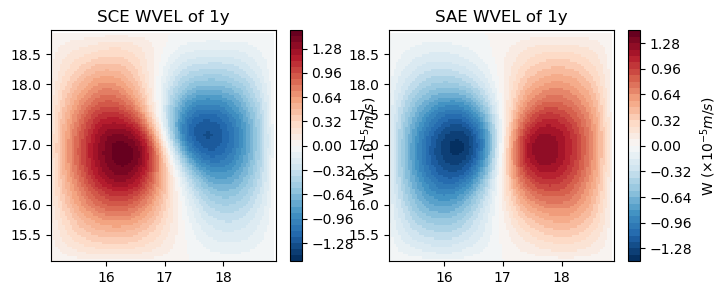

In [14]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
(w_SCE[8,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE WVEL of '+var)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
(w_SAE[8,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE WVEL of '+var)
plt.xlabel('')
plt.ylabel('')


Text(0, 0.5, '')

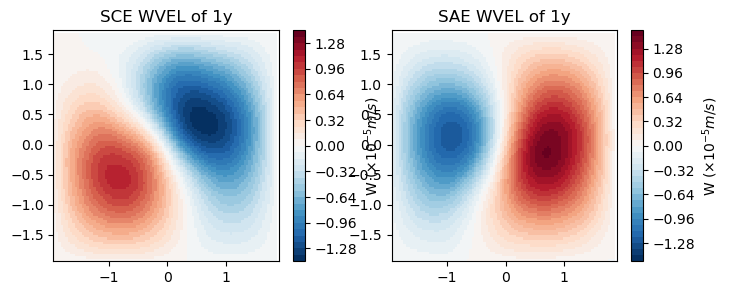

In [7]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
(w_SCE[8,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE WVEL of '+var)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
(w_SAE[8,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE WVEL of '+var)
plt.xlabel('')
plt.ylabel('')


In [ ]:
%%time
X,Y = np.meshgrid(w_xinvert.XC,w_xinvert.YC)

dipole_qx = np.zeros([101,101])*np.nan
dipole_qy = np.zeros([101,101])*np.nan
for i in np.arange(0,101,4):
    for j in np.arange(0,101,4):
        dipole_qx[i,j] = np.mean(Qx[6:17,:,:],0)[i,j]
        dipole_qy[i,j] = np.mean(Qy[6:17,:,:],0)[i,j]

In [ ]:
# diag dipole_w
fig = plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# (np.mean(w_xinvert[6:17,2:98,2:98],0)*100000).plot(cmap='RdBu_r', cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# plt.title('mean W')
# plt.xlabel('')
# plt.ylabel('')

plt.subplot(1, 2, 1)
np.mean(FQvec[6:17,2:98,2:98],0).plot(cmap='RdBu_r', vmax=2e-19, vmin=-2e-19, cbar_kwargs=dict(label=r'divQ'))
plt.quiver(X,Y,-dipole_qx,-dipole_qy,scale=2.5e-13)
plt.title('Q-vector & divQ')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
divQ[:,51,2:98].plot(cmap='RdBu_r', vmax=15e-19, vmin=-15e-19, cbar_kwargs=dict(label=r'divQ'))
# plt.quiver(X,Y,-dipole_qx,-dipole_qy,scale=2.5e-13)
plt.title('divQ')
plt.xlabel('')
plt.ylabel('')
plt.ylim([-1000,0])

savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

In [ ]:
### 保存QG反演的 W 和 divQ
w_xinvert.to_netcdf('/data3/home/zhangrd/data/compoed_sub_xinvert/a2_climw.nc')
FQvec.to_netcdf('/data3/home/zhangrd/data/compoed_sub_xinvert/a2_climdivQ.nc')
Qx.to_netcdf('/data3/home/zhangrd/data/compoed_sub_xinvert/a2_climQx.nc')
Qy.to_netcdf('/data3/home/zhangrd/data/compoed_sub_xinvert/a2_climQy.nc')

## 2. extension dipole

In [56]:
from xinvert import FiniteDiff
fd = FiniteDiff({'X':'XC', 'Y':'YC', 'Z':'Z'},
                BCs={'X':('extend','extend'),
                     'Y':('extend','extend'),
                     'Z':('extend','extend')}, fill=0, coords='lat-lon')

In [57]:
#########  frt双核  ##########
area='frt' #sub/frt

var = '1y' #1y/clim/anom
file_paths = {
    '1y': {
        'ece_u': '/data3/home/zhangrd/data/compoed_frt_variables/c2_1yu.nc',
        'ece_v': '/data3/home/zhangrd/data/compoed_frt_variables/c2_1yv.nc',
        'ece_w': '/data3/home/zhangrd/data/compoed_frt_variables/c2_1yw.nc',
        'ece_t': '/data3/home/zhangrd/data/compoed_frt_variables/c2_1yt.nc',
        'ece_e': '/data3/home/zhangrd/data/compoed_frt_variables/c2_1ye.nc',
        'eae_u': '/data3/home/zhangrd/data/compoed_frt_variables/a2_1yu.nc',
        'eae_v': '/data3/home/zhangrd/data/compoed_frt_variables/a2_1yv.nc',
        'eae_w': '/data3/home/zhangrd/data/compoed_frt_variables/a2_1yw.nc',
        'eae_t': '/data3/home/zhangrd/data/compoed_frt_variables/a2_1yt.nc',
        'eae_e': '/data3/home/zhangrd/data/compoed_frt_variables/a2_1ye.nc',},
    'clim': {
        'ece_u': '/data3/home/zhangrd/data/compoed_frt_variables/c2_climu.nc',
        'ece_v': '/data3/home/zhangrd/data/compoed_frt_variables/c2_climv.nc',
        'ece_w': '/data3/home/zhangrd/data/compoed_frt_variables/c2_climw.nc',
        'ece_t': '/data3/home/zhangrd/data/compoed_frt_variables/c2_climt.nc',
        'ece_e': '/data3/home/zhangrd/data/compoed_frt_variables/c2_clime.nc',
        'eae_u': '/data3/home/zhangrd/data/compoed_frt_variables/a2_climu.nc',
        'eae_v': '/data3/home/zhangrd/data/compoed_frt_variables/a2_climv.nc',
        'eae_w': '/data3/home/zhangrd/data/compoed_frt_variables/a2_climw.nc',
        'eae_t': '/data3/home/zhangrd/data/compoed_frt_variables/a2_climt.nc',
        'eae_e': '/data3/home/zhangrd/data/compoed_frt_variables/a2_clime.nc',},
    'anom': {
        'ece_u': '/data3/home/zhangrd/data/compoed_frt_variables/c2_ua.nc',
        'ece_v': '/data3/home/zhangrd/data/compoed_frt_variables/c2_va.nc',
        'ece_w': '/data3/home/zhangrd/data/compoed_frt_variables/c2_wa.nc',
        'ece_t': '/data3/home/zhangrd/data/compoed_frt_variables/c2_ta.nc',
        'ece_e': '/data3/home/zhangrd/data/compoed_frt_variables/c2_ea.nc',
        'eae_u': '/data3/home/zhangrd/data/compoed_frt_variables/a2_ua.nc',
        'eae_v': '/data3/home/zhangrd/data/compoed_frt_variables/a2_va.nc',
        'eae_w': '/data3/home/zhangrd/data/compoed_frt_variables/a2_wa.nc',
        'eae_t': '/data3/home/zhangrd/data/compoed_frt_variables/a2_ta.nc',
        'eae_e': '/data3/home/zhangrd/data/compoed_frt_variables/a2_ea.nc',},
}

if var not in file_paths:
    raise ValueError(f'invalid var: {var}')

paths = file_paths[var]
ECE_u = xr.open_dataset(paths['ece_u']).UVEL
ECE_v = xr.open_dataset(paths['ece_v']).VVEL
ECE_w = xr.open_dataset(paths['ece_w']).WVEL
ECE_t = xr.open_dataset(paths['ece_t']).THETA
ECE_e = xr.open_dataset(paths['ece_e']).ETAN
EAE_u = xr.open_dataset(paths['eae_u']).UVEL
EAE_v = xr.open_dataset(paths['eae_v']).VVEL
EAE_w = xr.open_dataset(paths['eae_w']).WVEL
EAE_t = xr.open_dataset(paths['eae_t']).THETA
EAE_e = xr.open_dataset(paths['eae_e']).ETAN

# 修改ECE坐标
xnew_coord = np.linspace(15, 19, 101)#生成新的XC坐标值 (替换原有坐标)
ynew_coord = np.linspace(30, 34, 101)#生成新的YC坐标值 (替换原有坐标)
lev=np.arange(-5,-1055,-50)
ECE_u = ECE_u.interp(Z=lev)
ECE_v = ECE_v.interp(Z=lev)
ECE_w = ECE_w.interp(Zl=lev)
ECE_t = ECE_t.interp(Z=lev)
ECE_u=ECE_u.rename({'XG': 'XC'})
ECE_v=ECE_v.rename({'YG': 'YC'})
# ECE_u = ECE_u.assign_coords(YC=ynew_coord, XC=xnew_coord)
# ECE_v = ECE_v.assign_coords(YC=ynew_coord, XC=xnew_coord)
# ECE_w = ECE_w.assign_coords(YC=ynew_coord, XC=xnew_coord)
# ECE_t = ECE_t.assign_coords(YC=ynew_coord, XC=xnew_coord)
# ECE_e = ECE_e.assign_coords(YC=ynew_coord, XC=xnew_coord)

# 修改EAE坐标
EAE_u = EAE_u.interp(Z=lev)
EAE_v = EAE_v.interp(Z=lev)
EAE_w = EAE_w.interp(Zl=lev)
EAE_t = EAE_t.interp(Z=lev)
EAE_u=EAE_u.rename({'XG': 'XC'})
EAE_v=EAE_v.rename({'YG': 'YC'})
# EAE_u = EAE_u.assign_coords(YC=ynew_coord, XC=xnew_coord)
# EAE_v = EAE_v.assign_coords(YC=ynew_coord, XC=xnew_coord)
# EAE_w = EAE_w.assign_coords(YC=ynew_coord, XC=xnew_coord)
# EAE_t = EAE_t.assign_coords(YC=ynew_coord, XC=xnew_coord)
# EAE_e = EAE_e.assign_coords(YC=ynew_coord, XC=xnew_coord)
# np.isnan(ECE_w.data).sum() #10201

In [58]:
%%time
g = 9.81
rho0 = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4 # degrees^-1
def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + rho0
    return rho

ECE_rho  = linear_rho(35, ECE_t, sref, tref)
EAE_rho  = linear_rho(35, EAE_t, sref, tref)
# sigma = linear_rho(35, temp, sref, tref) - 1000 # sigma is " rho' "

# g = 9.81  # unit：m/s^2
# rho0 = 999.8  # 海水的平均密度，模式输出rhoRef为999.8，unit：kg/m^3
# sref = 35 # 绝对盐度为35, unit: g/kg
# h = xr.DataArray(-lev, dims=['Z'], coords={'Z':lev}).broadcast_like(ECE_t)  # 自动扩展到相同维度
# ### ECE
# ECE_pref = rho0 * g * (h + ECE_e) # 计算静力近似的压力场 pref 以便进一步计算rho,pref只与垂直维度Z相关
# ECE_CT = gsw.CT_from_pt(sref, ECE_t) # 由位温计算保守温度CT（Conservative Temperature）
# ECE_rho= gsw.rho(sref,ECE_CT,ECE_pref/1e4) # p_ref/1e4：帕转换为分巴, unit:dbar. (absolute pressure minus 10.1325 dbar)
# ### EAE
# EAE_pref = rho0 * g * (h + EAE_e)
# EAE_CT = gsw.CT_from_pt(sref, EAE_t)
# EAE_rho= gsw.rho(sref,EAE_CT,EAE_pref/1e4)


ECE_b  = ECE_rho * (-g/rho0)
EAE_b  = EAE_rho * (-g/rho0)
omg = 2*math.pi/(86400) # unit: rad/s
# f  = 2*omg*np.sin(np.deg2rad(dipole_t.YC))
ECE_N2 = ECE_b.mean(['YC','XC']).load().differentiate('Z').load()
EAE_N2 = EAE_b.mean(['YC','XC']).load().differentiate('Z').load()

CPU times: user 11.2 ms, sys: 5.63 ms, total: 16.9 ms
Wall time: 14.3 ms


In [ ]:
%%time
########## traditional form of forcings ##########
# ECE_bx, ECE_by = fd.grad(ECE_b, ['X', 'Y'])
# EAE_bx, EAE_by = fd.grad(EAE_b, ['X', 'Y'])
# ECE_zx, ECE_zy = fd.grad(fd.curl(ECE_u, ECE_u), ['X', 'Y'])
# EAE_zx, EAE_zy = fd.grad(fd.curl(EAE_u, EAE_u), ['X', 'Y'])

# ECE_adv_b = ECE_u*ECE_bx + ECE_v*ECE_by
# ECE_adv_z = ECE_u*ECE_zx + ECE_v*ECE_zy
# EAE_adv_b = EAE_u*EAE_bx + EAE_v*EAE_by
# EAE_adv_z = EAE_u*EAE_zx + EAE_v*EAE_zy

# Ftrad_ECE = fd.Laplacian(-ECE_adv_b, ['X', 'Y']) + ECE_adv_z.load().differentiate('Z')*f
# Ftrad_ECE = (xr.where(np.isfinite(Ftrad_ECE), Ftrad_ECE, np.nan)).load()
# Ftrad_EAE = fd.Laplacian(-EAE_adv_b, ['X', 'Y']) + EAE_adv_z.load().differentiate('Z')*f
# Ftrad_EAE = (xr.where(np.isfinite(Ftrad_EAE), Ftrad_EAE, np.nan)).load()
# # can not use because the 'f' is not defined and calculated

In [59]:
%%time
############ Q-vector form of forcings ############
######ECE
ECE_bx, ECE_by = fd.grad(ECE_b, ['X', 'Y'])
ECE_ux, ECE_uy = fd.grad(ECE_u, ['X', 'Y'])
ECE_vx, ECE_vy = fd.grad(ECE_v, ['X', 'Y'])
ECE_Qx = ECE_ux*ECE_bx + ECE_vx*ECE_by
ECE_Qy = ECE_uy*ECE_bx + ECE_vy*ECE_by
ECE_divQ  = -2 * fd.divg((ECE_Qx, ECE_Qy), ['X', 'Y'])
FQvec_ECE = xr.where(np.isfinite(ECE_divQ), ECE_divQ, np.nan).load() #将divQ中的非有限值（如inf）替换为NaN
# FQvec为处理后的散度场
# .load() 将延迟计算的Dask数组转为内存中的NumPy数组（加速后续操作）。

######EAE
EAE_bx, EAE_by = fd.grad(EAE_b, ['X', 'Y'])
EAE_ux, EAE_uy = fd.grad(EAE_u, ['X', 'Y'])
EAE_vx, EAE_vy = fd.grad(EAE_v, ['X', 'Y'])
EAE_Qx = EAE_ux*EAE_bx + EAE_vx*EAE_by
EAE_Qy = EAE_uy*EAE_bx + EAE_vy*EAE_by
EAE_divQ  = -2 * fd.divg((EAE_Qx, EAE_Qy), ['X', 'Y'])
FQvec_EAE = xr.where(np.isfinite(EAE_divQ), EAE_divQ, np.nan).load()

CPU times: user 1.14 s, sys: 177 ms, total: 1.32 s
Wall time: 1.17 s


In [60]:
############ calculate beta effect term ############
#假设合成后的矩形范围位于30-34°N
omg   = 2*math.pi/(86400) # unit: rad/s
frt_f = 2*omg*np.sin(np.deg2rad(ECE_v.YC))
frt_f_3d = frt_f.broadcast_like(ECE_v)# 将frt_f广播到三维空间
beta=fd.grad(frt_f_3d, ['Y']) #beta.values

######ECE
ECE_vz=fd.grad(ECE_v, ['Z'])
ECE_betaterm = frt_f_3d * beta * ECE_vz
######EAE
EAE_vz=fd.grad(EAE_v, ['Z'])
EAE_betaterm = frt_f_3d * beta * EAE_vz

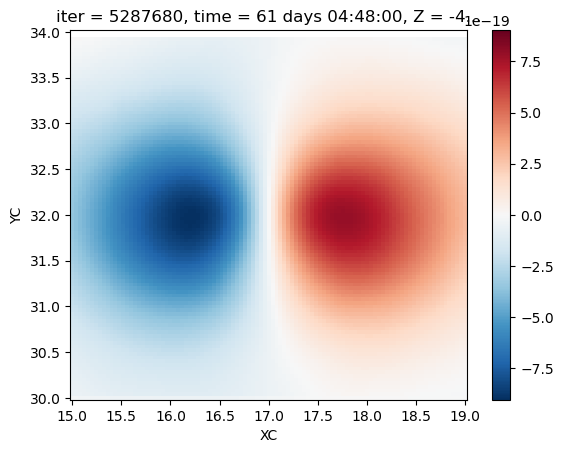

In [26]:
ECE_betaterm[8].plot()

In [23]:
%%time
from xinvert import invert_omega
iParams = {
    'BCs'      : ['fixed', 'fixed', 'extend'],
    'mxLoop'   : 500,
    'tolerance': 1e-9,}

mParams = {'N2': ECE_N2} #'1y'和'clim'的N2都是正的，但anom的N2存在许多负值，这是有问题的
# w1 = invert_omega(Ftrad, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
w_ECE = invert_omega((FQvec_ECE+ECE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

mParams = {'N2': EAE_N2} #'1y'和'clim'的N2都是正的，但anom的N2存在许多负值，这是有问题的
# w1 = invert_omega(Ftrad, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
w_EAE = invert_omega((FQvec_EAE+EAE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

{} loops  140 and tolerance is 9.378269e-10
{} loops  128 and tolerance is 9.248367e-10
CPU times: user 1.09 s, sys: 105 ms, total: 1.19 s
Wall time: 1.12 s


Text(0, 0.5, '')

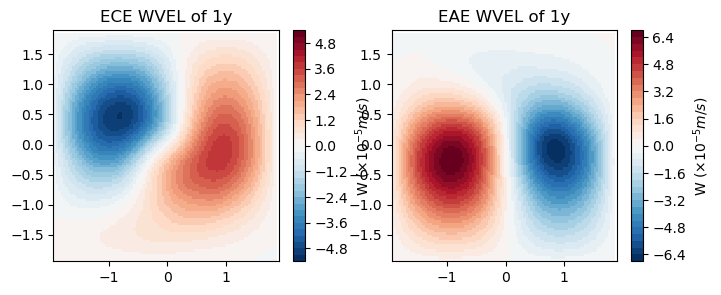

In [30]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
(w_ECE[8,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE WVEL of '+var)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
(w_EAE[8,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE WVEL of '+var)
plt.xlabel('')
plt.ylabel('')


In [ ]:
%%time
X,Y = np.meshgrid(w_xinvert.XC,w_xinvert.YC)

dipole_qx = np.zeros([101,101])*np.nan
dipole_qy = np.zeros([101,101])*np.nan
for i in np.arange(0,101,4):
    for j in np.arange(0,101,4):
        dipole_qx[i,j] = np.mean(Qx[6:17,:,:],0)[i,j]
        dipole_qy[i,j] = np.mean(Qy[6:17,:,:],0)[i,j]

In [ ]:
# diag c2w
fig = plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# (np.mean(w_xinvert[6:17,2:98,2:98],0)*100000).plot(cmap='RdBu_r', cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# plt.title('mean W')
# plt.xlabel('')
# plt.ylabel('')

plt.subplot(1, 2, 1)
np.mean(FQvec[6:17,2:98,2:98],0).plot(cmap='RdBu_r', vmax=4e-19, vmin=-4e-19, cbar_kwargs=dict(label=r'divQ'))
plt.quiver(X,Y,-dipole_qx,-dipole_qy,scale=1e-12)
plt.title('Q-vector & divQ')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
divQ[:,51,2:98].plot(cmap='RdBu_r', vmax=20e-19, vmin=-20e-19, cbar_kwargs=dict(label=r'divQ'))
# plt.quiver(X,Y,-c2qx,-c2qy,scale=2.5e-13)
plt.title('divQ')
plt.xlabel('')
plt.ylabel('')
plt.ylim([-1000,0])

savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

In [ ]:
### 保存QG反演的 W 和 divQ
w_xinvert.to_netcdf('/data3/home/zhangrd/data/compoed_frt_xinvert/a2_1yw.nc')
FQvec.to_netcdf('/data3/home/zhangrd/data/compoed_frt_xinvert/a2_1ydivQ.nc')
Qx.to_netcdf('/data3/home/zhangrd/data/compoed_frt_xinvert/a2_1yQx.nc')
Qy.to_netcdf('/data3/home/zhangrd/data/compoed_frt_xinvert/a2_1yQy.nc')

## 6. experiments

### 6.1 subtropical dipole

In [3]:
from xinvert import FiniteDiff
fd = FiniteDiff({'X':'XC', 'Y':'YC', 'Z':'Z'},
                BCs={'X':('extend','extend'),
                     'Y':('extend','extend'),
                     'Z':('extend','extend')}, fill=0, coords='lat-lon')

In [4]:
#########  sub双核  ##########
SCE_1yt = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yt.nc').THETA
SCE_1ye = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_1ye.nc').ETAN
SCE_climt = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_climt.nc').THETA #SCE的climt，和SCE_anomt一起计算无水平梯度的涡旋背景密度
SCE_clime = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_clime.nc').ETAN
SCE_anomt = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_ta.nc').THETA
SCE_anome = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_ea.nc').ETAN
SCE_anomu = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_ua.nc').UVEL
SCE_anomv = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_va.nc').VVEL
# SCE_anomw = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_wa.nc').WVEL

SAE_1yt = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yt.nc').THETA
SAE_1ye = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_1ye.nc').ETAN
SAE_climt = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_climt.nc').THETA #SAE的climt，和SAE_anomt一起计算无水平梯度的涡旋背景密度
SAE_clime = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_clime.nc').ETAN
SAE_anomt = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_ta.nc').THETA
SAE_anome = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_ea.nc').ETAN
SAE_anomu = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_ua.nc').UVEL
SAE_anomv = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_va.nc').VVEL

# 修改SCE坐标
new_coord = np.linspace(15, 19, 101)#生成新的坐标值 (替换原有坐标)
lev=np.arange(-5,-1055,-50)
SCE_1yt   = SCE_1yt.interp(Z=lev)
SCE_climt = SCE_climt.interp(Z=lev)
SCE_anomt = SCE_anomt.interp(Z=lev)
SCE_anomu = SCE_anomu.interp(Z=lev)
SCE_anomv = SCE_anomv.interp(Z=lev)
SCE_anomu=SCE_anomu.rename({'XG': 'XC'})
SCE_anomv=SCE_anomv.rename({'YG': 'YC'})
SCE_1yt = SCE_1yt.assign_coords(YC=new_coord, XC=new_coord)
SCE_1ye = SCE_1ye.assign_coords(YC=new_coord, XC=new_coord)
SCE_climt = SCE_climt.assign_coords(YC=new_coord, XC=new_coord)
SCE_clime = SCE_clime.assign_coords(YC=new_coord, XC=new_coord)
SCE_anomt = SCE_anomt.assign_coords(YC=new_coord, XC=new_coord)
SCE_anome = SCE_anome.assign_coords(YC=new_coord, XC=new_coord)
SCE_anomu = SCE_anomu.assign_coords(YC=new_coord, XC=new_coord)
SCE_anomv = SCE_anomv.assign_coords(YC=new_coord, XC=new_coord)


SAE_1yt   = SAE_1yt.interp(Z=lev)
SAE_climt = SAE_climt.interp(Z=lev)
SAE_anomt = SAE_anomt.interp(Z=lev)
SAE_anomu = SAE_anomu.interp(Z=lev)
SAE_anomv = SAE_anomv.interp(Z=lev)
SAE_anomu=SAE_anomu.rename({'XG': 'XC'})
SAE_anomv=SAE_anomv.rename({'YG': 'YC'})
SAE_1yt = SAE_1yt.assign_coords(YC=new_coord, XC=new_coord)
SAE_1ye = SAE_1ye.assign_coords(YC=new_coord, XC=new_coord)
SAE_climt = SAE_climt.assign_coords(YC=new_coord, XC=new_coord)
SAE_clime = SAE_clime.assign_coords(YC=new_coord, XC=new_coord)
SAE_anomt = SAE_anomt.assign_coords(YC=new_coord, XC=new_coord)
SAE_anome = SAE_anome.assign_coords(YC=new_coord, XC=new_coord)
SAE_anomu = SAE_anomu.assign_coords(YC=new_coord, XC=new_coord)
SAE_anomv = SAE_anomv.assign_coords(YC=new_coord, XC=new_coord)

In [5]:
%%time
g = 9.81
rho0 = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4 # degrees^-1
def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + rho0
    return rho

SCE_climrho= linear_rho(35, SCE_climt, sref, tref)
SAE_climrho= linear_rho(35, SAE_climt, sref, tref)
# SCE_anomrho= linear_rho(35, SCE_anomt, sref, tref)
# SAE_anomrho= linear_rho(35, SAE_anomt, sref, tref)
SCE_1yrho= linear_rho(35, SCE_1yt, sref, tref)
SAE_1yrho= linear_rho(35, SAE_1yt, sref, tref)
SCE_anomrho= SCE_1yrho-SCE_climrho
SAE_anomrho= SAE_1yrho-SAE_climrho

# g = 9.81  # unit：m/s^2
# rho0 = 999.8  # 海水的平均密度，模式输出rhoRef为999.8，unit：kg/m^3
# sref = 35 # 绝对盐度为35, unit: g/kg
# h = xr.DataArray(-lev, dims=['Z'], coords={'Z':lev}).broadcast_like(SCE_climt)  # 自动扩展到相同维度
# ### SCE
# SCE_climpref = rho0 * g * (h + SCE_clime) # 计算静力近似的压力场 pref 以便进一步计算rho,pref只与垂直维度Z相关
# SCE_climCT = gsw.CT_from_pt(sref, SCE_climt) # 由位温计算保守温度CT（Conservative Temperature）
# SCE_climrho= gsw.rho(sref,SCE_climCT,SCE_climpref/1e4) # p_ref/1e4：帕转换为分巴, unit:dbar. (absolute pressure minus 10.1325 dbar)
# SCE_anompref = rho0 * g * (h + SCE_anome)
# SCE_anomCT = gsw.CT_from_pt(sref, SCE_anomt)
# SCE_anomrho= gsw.rho(sref,SCE_anomCT,SCE_anompref/1e4)
# ### SAE
# SAE_climpref = rho0 * g * (h + SAE_clime)
# SAE_climCT = gsw.CT_from_pt(sref, SAE_climt)
# SAE_climrho= gsw.rho(sref,SAE_climCT,SAE_climpref/1e4)
# SAE_anompref = rho0 * g * (h + SAE_anome)
# SAE_anomCT = gsw.CT_from_pt(sref, SAE_anomt)
# SAE_anomrho= gsw.rho(sref,SAE_anomCT,SAE_anompref/1e4)

SCE_hmean = SCE_climrho.mean(dim=['YC', 'XC']) + SCE_anomrho #SCE_hmean：平均掉气候态rho的水平梯度但保留垂直梯度，然后以此为背景再加上涡旋本身anomaly的密度信号
SAE_hmean = SAE_climrho.mean(dim=['YC', 'XC']) + SAE_anomrho


CPU times: user 25.2 ms, sys: 3.2 ms, total: 28.4 ms
Wall time: 33.7 ms


In [6]:
#################################################
########## 把SCE和SAE的hmean密度做成正圆 ##########
#################################################

######## 相关参数和函数 ########
YC=np.linspace(-2, 2, 101) #笛卡尔坐标下原始坐标
XC=np.linspace(-2, 2, 101)
new_YC=np.linspace(-2.84, 2.84, 143) #笛卡尔坐标下扩展坐标（极坐标直径）
new_XC=np.linspace(-2.84, 2.84, 143)
X, Y  =np.meshgrid(new_XC, new_YC) #X为笛卡尔坐标下每个格点处的x索引，Y为笛卡尔坐标下每个格点处的y索引
sx,sy = int((len(new_XC)-1)/2-50) , int((len(new_YC)-1)/2-50)
ex,ey = int((len(new_XC)-1)/2+50+1) , int((len(new_YC)-1)/2+50+1)
# 极坐标参数
r = new_XC[int((len(new_XC)-1)/2):] #半径范围
th= np.linspace(0, 2*np.pi, 361) #角度范围
R, Th = np.meshgrid(r, th)
X_r,Y_r = R*np.cos(Th), R*np.sin(Th) #笛卡尔坐标系下的极坐标点的位置索引

######## 定义函数1（创造更大网格以包含外接圆）
def expand_grid(da, new_YC, new_XC): #！！！扩大后的网格需要：1.Z轴与原数组一致、2.每层以原数组的中心为中心、3.dx和dy与原数组一致
    bigdata = np.ones((len(da.Z),len(new_YC),len(new_XC)))*np.nan
    bigdata[:,sy:ey,sx:ex]=da
    big_da = xr.DataArray(data=bigdata, dims=da.dims,
                          coords={'Z': da.Z,'YC': new_YC,'XC': new_XC})
    return big_da
######## 定义函数2（插值到极坐标下的外接圆）
def interp2polar(big_da, X, Y, X_r, Y_r):
    cart_points = np.vstack([X.ravel(), Y.ravel()]).T  # 原始笛卡尔坐标点
    polar_points= np.vstack([X_r.ravel(), Y_r.ravel()]).T  # 目标极坐标对应的笛卡尔点
    # 对每个Z层分别插值
    Z_len = big_da.sizes['Z']
    th_len, r_len = X_r.shape
    interp_data = np.full((Z_len, th_len, r_len), np.nan)
    for i in range(Z_len):
        values = big_da.isel(Z=i).values.ravel()
        interp_layer = griddata(cart_points, values, polar_points, method='linear')
        interp_data[i, :, :] = interp_layer.reshape((th_len, r_len))
    # 构造新的xarray.DataArray输出
    interp_da = xr.DataArray(data=interp_data,dims=['Z', 'theta', 'r'],
                             coords={'Z': big_da.Z.values,'theta': th,'r': r})
    return interp_da
######## 定义函数3（平均成正圆）
def makecircle(interp_da): # mean to make circle
    mean_da = interp_da.mean(dim='theta', skipna=True) #在 theta 上求平均,xarray本身默认即跳过NaN
    circle_da = mean_da.broadcast_like(interp_da)  # 直接扩展广播回到原形状，成为正圆
    return circle_da
######## 定义函数4（正圆插值回原网格）
def interpback(circle_da, XC, YC, X_r, Y_r): # interp back
    points_polar = np.vstack([X_r.ravel(), Y_r.ravel()]).T  #(361*72, 2)
    XC_grid, YC_grid = np.meshgrid(XC, YC) #生成目标笛卡尔网格
    points_cart = np.vstack([XC_grid.ravel(), YC_grid.ravel()]).T  #(101*101, 2)
    interp_data = np.full((len(circle_da.Z), len(YC), len(XC)), np.nan) #初始化结果数组
    # 逐层插值
    for zz in range(len(circle_da.Z)):
        values = circle_da.isel(Z=zz).values.ravel() #提取当前层数据并展平
        # 执行插值（线性插值）
        interp_layer = griddata(points_polar,          # 原始点坐标
                                values,                # 原始点值
                                points_cart,           # 目标点坐标
                                method='linear',       # 插值方法
                                fill_value=np.nan)     # 填充值
        # 重塑并存储结果
        interp_data[zz] = interp_layer.reshape((len(YC), len(XC)))
    # 构建xarray对象
    back_da = xr.DataArray(data=interp_data,dims=['Z', 'YC', 'XC'],
                           coords={'Z': circle_da.Z,'YC': YC,'XC': XC})
    return back_da

######## 函数要求 ########
# da需是三维xarray数组, Z:21,YC:101,XC:101
# expand_grid扩大后的网格要求：1.Z轴与原数组一致、2.每层以原数组的中心为中心、3.dx和dy与原数组一致

In [7]:
%%time
SCE_anome_expand = SCE_anome.expand_dims(Z=[-5], axis=0)
SAE_anome_expand = SAE_anome.expand_dims(Z=[-5], axis=0)
SCE_anome3d = SCE_anome_expand.transpose('Z', 'YC', 'XC')
SAE_anome3d = SAE_anome_expand.transpose('Z', 'YC', 'XC')

big_SCE_hmean=expand_grid(SCE_hmean, new_YC, new_XC)
big_SAE_hmean=expand_grid(SAE_hmean, new_YC, new_XC)
big_SCE_anome=expand_grid(SCE_anome3d, new_YC, new_XC)
big_SAE_anome=expand_grid(SAE_anome3d, new_YC, new_XC)

interp_SCE_hmean=interp2polar(big_SCE_hmean, X, Y, X_r, Y_r)
interp_SAE_hmean=interp2polar(big_SAE_hmean, X, Y, X_r, Y_r)
interp_SCE_anome=interp2polar(big_SCE_anome, X, Y, X_r, Y_r)
interp_SAE_anome=interp2polar(big_SAE_anome, X, Y, X_r, Y_r)

circle_SCE_hmean=makecircle(interp_SCE_hmean)
circle_SAE_hmean=makecircle(interp_SAE_hmean)
circle_SCE_anome=makecircle(interp_SCE_anome)
circle_SAE_anome=makecircle(interp_SAE_anome)

back_SCE_hmean=interpback(circle_SCE_hmean, XC, YC, X_r, Y_r)
back_SAE_hmean=interpback(circle_SAE_hmean, XC, YC, X_r, Y_r)
back_SCE_anome=interpback(circle_SCE_anome, XC, YC, X_r, Y_r)
back_SAE_anome=interpback(circle_SAE_anome, XC, YC, X_r, Y_r)

#按照副热带区域修改经纬坐标
back_SCE_hmean = back_SCE_hmean.assign_coords(YC=new_coord, XC=new_coord)
back_SAE_hmean = back_SAE_hmean.assign_coords(YC=new_coord, XC=new_coord)
back_SCE_anome = back_SCE_anome.assign_coords(YC=new_coord, XC=new_coord)
back_SAE_anome = back_SAE_anome.assign_coords(YC=new_coord, XC=new_coord)

CPU times: user 40.3 s, sys: 33.3 s, total: 1min 13s
Wall time: 55.7 s


Text(0, 0.5, '')

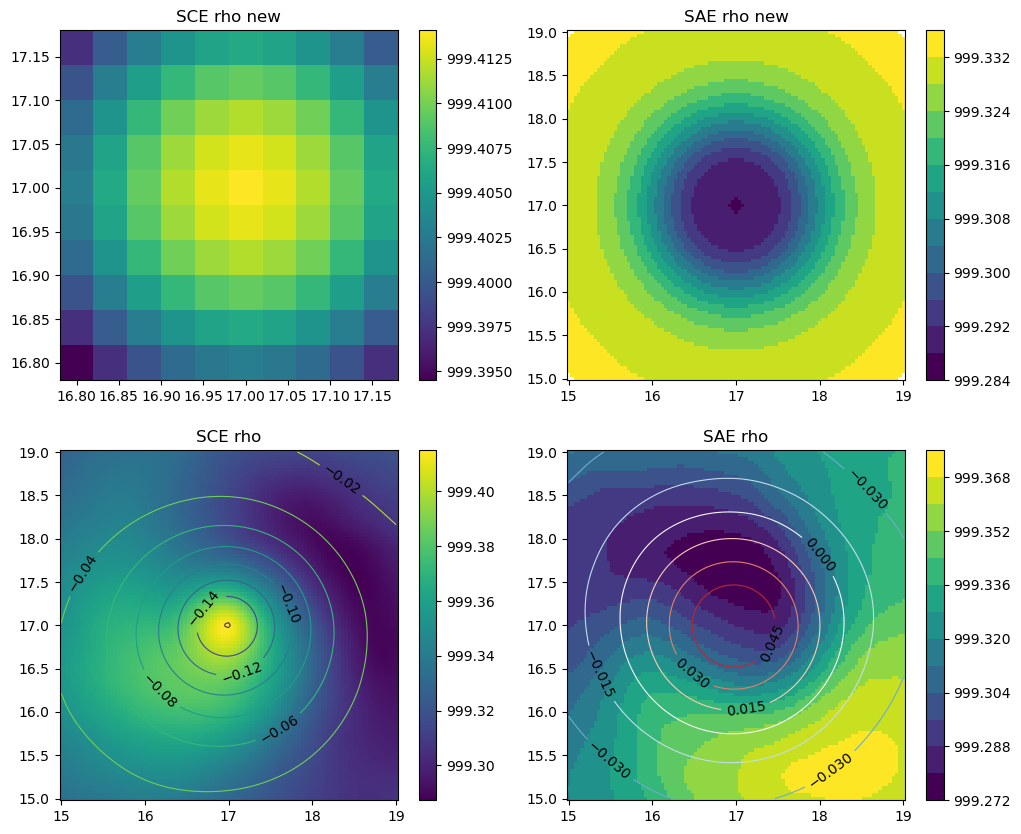

In [8]:
z=1
fig = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
(back_SCE_hmean[z,45:55,45:55]).plot(cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)levels=15, 
# dd = (SCE_anome_new).plot.contour(levels=10, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('SCE rho new')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(back_SAE_hmean[z,]).plot(levels=15, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (SAE_anome_new).plot.contour(levels=10, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('SAE rho new')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(SCE_hmean[z,]).plot(cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)levels=15, 
dd = (SCE_anome).plot.contour(levels=10, linewidths=.8)
plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('SCE rho')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(SAE_hmean[z,]).plot(levels=15, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
dd = (SAE_anome).plot.contour(levels=10, linewidths=.8)
plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('SAE rho')
plt.xlabel('')
plt.ylabel('')

In [9]:
######## ρgdz计算每层压力p,然后积分求出实际p,进一步求地转uv ########
###求每层p
dz=50
SCE_dzpre=xr.zeros_like(back_SCE_hmean) #单层p
SAE_dzpre=xr.zeros_like(back_SAE_hmean)
# SCE_dzpre[0,:,:]=p0 #SCE第0层上表面p
# SAE_dzpre[0,:,:]=p0
SCE_dzpre[0,:,:]=back_SCE_hmean[0]*g*(-back_SCE_hmean.Z[0]+(dz/2)+back_SCE_anome[0]) #SCE第0层下表面单层p
SAE_dzpre[0,:,:]=back_SAE_hmean[0]*g*(-back_SAE_hmean.Z[0]+(dz/2)+back_SAE_anome[0])
for i in np.arange(1,20):
    SCE_dzpre[i,:,:]=back_SCE_hmean[i,:,:]*g*dz #第i层下表面处的单层p
    SAE_dzpre[i,:,:]=back_SAE_hmean[i,:,:]*g*dz

###积分求实际p
SCE_pre=xr.zeros_like(back_SCE_hmean) #单层p求和积分后的实际p
SAE_pre=xr.zeros_like(back_SAE_hmean)
SCE_pre[0,:,:]=back_SCE_hmean[0]*g*(-back_SCE_hmean.Z[0]+back_SCE_anome[0]) #SCE第0层p
SAE_pre[0,:,:]=back_SAE_hmean[0]*g*(-back_SAE_hmean.Z[0]+back_SAE_anome[0])
for i in np.arange(1,21):
    SCE_pre[i,:,:]=SCE_dzpre[:i,:,:].sum(dim='Z')+back_SCE_hmean[i]*g*(dz/2)
    SAE_pre[i,:,:]=SAE_dzpre[:i,:,:].sum(dim='Z')+back_SAE_hmean[i]*g*(dz/2)

In [10]:
###求地转流uv
# SCE_p=SCE_pre.assign_coords({'XC': np.linspace(19.5, 20.5, 101),'YC': np.linspace(19.5, 20.5, 101)})
# SAE_p=SCE_pre.assign_coords({'XC': np.linspace(19.5, 20.5, 101),'YC': np.linspace(19.5, 20.5, 101)})
# omg   = 2*math.pi/(86400) # unit: rad/s
# sub_f0= 2*omg*np.sin(np.deg2rad(20)) #以20°N为f0
# SCE_prex, SCE_prey = fd.grad(SCE_p, ['X', 'Y'])
# SAE_prex, SAE_prey = fd.grad(SAE_p, ['X', 'Y'])

omg   = 2*math.pi/(86400) # unit: rad/s
sub_f0= 2*omg*np.sin(np.deg2rad(15)) #以15°N为f0
SCE_prex, SCE_prey = fd.grad(SCE_pre, ['X', 'Y'])
SAE_prex, SAE_prey = fd.grad(SAE_pre, ['X', 'Y'])

SCE_anomug = -SCE_prey/(rho0*sub_f0)
SCE_anomvg = SCE_prex/(rho0*sub_f0)
SAE_anomug = -SAE_prey/(rho0*sub_f0)
SAE_anomvg = SAE_prex/(rho0*sub_f0)

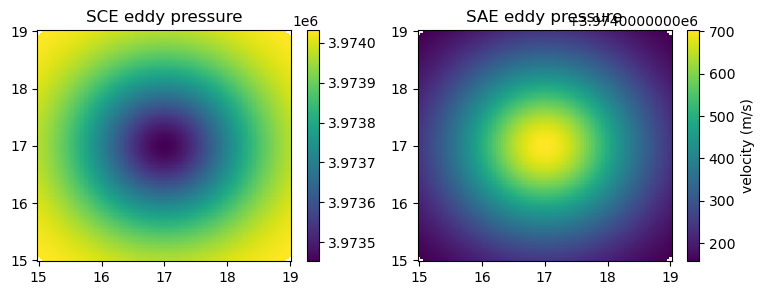

In [11]:
# SCE和SAE 压强pre(无NaN值)
z=8
lev=np.linspace(-0.12,0.12,25)
# lev=25
fig = plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
(SCE_pre[z,]).plot(cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)levels=lev, 
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE eddy pressure')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
(SAE_pre[z,]).plot(cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE eddy pressure')
plt.xlabel('')
plt.ylabel('')

savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

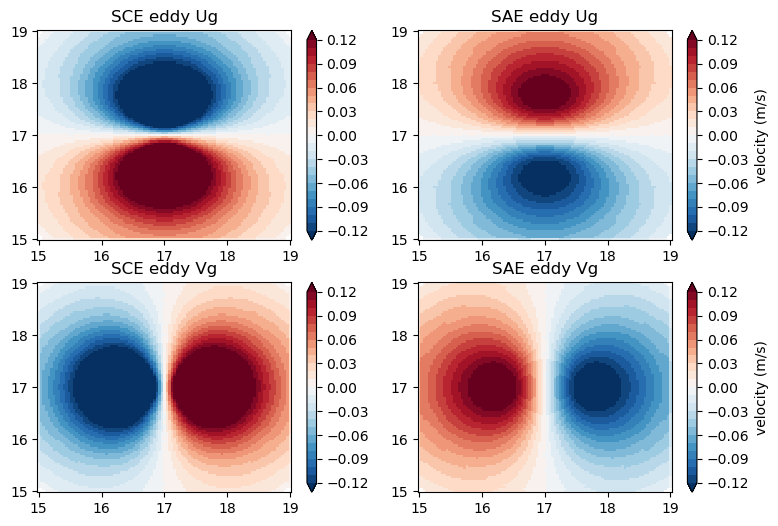

In [12]:
# SCE和SAE 地转流UV(无NaN值)
z=0
lev=np.linspace(-0.12,0.12,25)
# lev=25
fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
(SCE_anomug[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE eddy Ug')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(SAE_anomug[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE eddy Ug')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(SCE_anomvg[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE eddy Vg')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(SAE_anomvg[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE eddy Vg')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

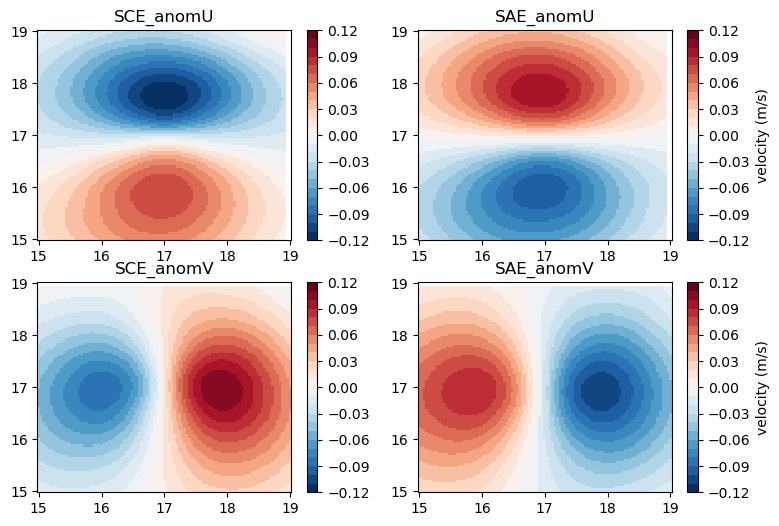

In [13]:
# SCE和SAE anomUV(有NaN值)
z=8
lev=np.linspace(-0.12,0.12,25)

fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
(SCE_anomu[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE_anomU')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(SAE_anomu[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE_anomU')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(SCE_anomv[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE_anomV')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(SAE_anomv[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE_anomV')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

In [14]:
########## 把SCE和SAE的climb在x方向进行平均 ##########
SCE_mean_xc = SCE_climrho.mean(dim='XC') #在 XC 维度上求平均，得到形状 (21, 101)
SAE_mean_xc = SAE_climrho.mean(dim='XC')
SCE_climrho_new = SCE_mean_xc * xr.ones_like(SCE_climrho) #均值广播回原始维度 (21, 101, 101)
SAE_climrho_new = SAE_mean_xc * xr.ones_like(SAE_climrho)

Text(0, 0.5, '')

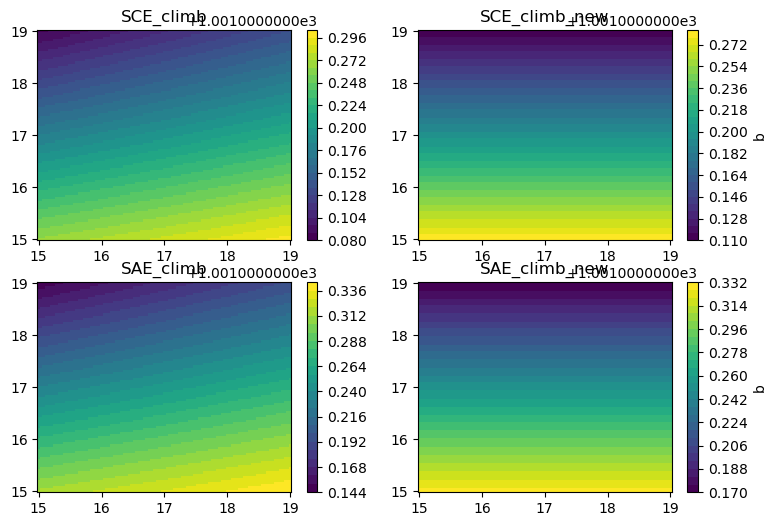

In [15]:
########## 检查climb_new的图像 ##########
z=8

fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
(SCE_climrho[z,]).plot(levels=30, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE_climb')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(SCE_climrho_new[z,]).plot(levels=30, cbar_kwargs=dict(label='b'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SCE_climb_new')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(SAE_climrho[z,]).plot(levels=30, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE_climb')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(SAE_climrho_new[z,]).plot(levels=30, cbar_kwargs=dict(label='b'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('SAE_climb_new')
plt.xlabel('')
plt.ylabel('')

In [16]:
# sigma = linear_rho(35, temp, sref, tref) - 1000 # sigma is " rho' "
SCE_climb = SCE_climrho_new * (-g/rho0)
SAE_climb = SAE_climrho_new * (-g/rho0)
SCE_hmeanb= back_SCE_hmean * (-g/rho0)
SAE_hmeanb= back_SAE_hmean * (-g/rho0)
# omg = 2*math.pi/(86400) # unit: rad/s
# f  = 2*omg*np.sin(np.deg2rad(dipole_t.YC))
SCE_climN2 = SCE_climb.mean(['YC','XC']).load().differentiate('Z').load()
SAE_climN2 = SAE_climb.mean(['YC','XC']).load().differentiate('Z').load()
SCE_hmeanN2= SCE_hmeanb.mean(['YC','XC']).load().differentiate('Z').load()
SAE_hmeanN2= SAE_hmeanb.mean(['YC','XC']).load().differentiate('Z').load()

In [17]:
%%time

SCE_anomux, SCE_anomuy = fd.grad(SCE_anomug, ['X', 'Y']) #改成了ugvg
SCE_anomvx, SCE_anomvy = fd.grad(SCE_anomvg, ['X', 'Y'])
SAE_anomux, SAE_anomuy = fd.grad(SAE_anomug, ['X', 'Y'])
SAE_anomvx, SAE_anomvy = fd.grad(SAE_anomvg, ['X', 'Y'])
############ Q-vector form：anomu/anomv和 climb_new ############
#####SCE
SCE_climbx, SCE_climby = fd.grad(SCE_climb, ['X', 'Y'])
Qx_SCEclimb = SCE_anomux*SCE_climbx + SCE_anomvx*SCE_climby
Qy_SCEclimb = SCE_anomuy*SCE_climbx + SCE_anomvy*SCE_climby
divQ_SCEclimb  = -2 * fd.divg((Qx_SCEclimb, Qy_SCEclimb), ['X', 'Y'])
FQvec_SCEclimb = xr.where(np.isfinite(divQ_SCEclimb), divQ_SCEclimb, np.nan).load()
#####SAE
SAE_climbx, SAE_climby = fd.grad(SAE_climb, ['X', 'Y'])
Qx_SAEclimb = SAE_anomux*SAE_climbx + SAE_anomvx*SAE_climby
Qy_SAEclimb = SAE_anomuy*SAE_climbx + SAE_anomvy*SAE_climby
divQ_SAEclimb  = -2 * fd.divg((Qx_SAEclimb, Qy_SAEclimb), ['X', 'Y'])
FQvec_SAEclimb = xr.where(np.isfinite(divQ_SAEclimb), divQ_SAEclimb, np.nan).load()
############ Q-vector form：anomu/anomv和 hmeanb_new ############
#####SCE
SCE_hmeanbx, SCE_hmeanby = fd.grad(SCE_hmeanb, ['X', 'Y'])
Qx_SCEhmeanb = SCE_anomux*SCE_hmeanbx + SCE_anomvx*SCE_hmeanby
Qy_SCEhmeanb = SCE_anomuy*SCE_hmeanbx + SCE_anomvy*SCE_hmeanby
divQ_SCEhmeanb  = -2 * fd.divg((Qx_SCEhmeanb, Qy_SCEhmeanb), ['X', 'Y'])
FQvec_SCEhmeanb = xr.where(np.isfinite(divQ_SCEhmeanb), divQ_SCEhmeanb, np.nan).load()
#####SAE
SAE_hmeanbx, SAE_hmeanby = fd.grad(SAE_hmeanb, ['X', 'Y'])
Qx_SAEhmeanb = SAE_anomux*SAE_hmeanbx + SAE_anomvx*SAE_hmeanby
Qy_SAEhmeanb = SAE_anomuy*SAE_hmeanbx + SAE_anomvy*SAE_hmeanby
divQ_SAEhmeanb  = -2 * fd.divg((Qx_SAEhmeanb, Qy_SAEhmeanb), ['X', 'Y'])
FQvec_SAEhmeanb = xr.where(np.isfinite(divQ_SAEhmeanb), divQ_SAEhmeanb, np.nan).load()

CPU times: user 1.13 s, sys: 31.8 ms, total: 1.16 s
Wall time: 1.54 s


In [18]:
############ calculate beta effect term ############
#假设合成后的矩形范围位于15-19°N
omg   = 2*math.pi/(86400) # unit: rad/s
sub_f = 2*omg*np.sin(np.deg2rad(SCE_anomvg.YC))
sub_f_3d = sub_f.broadcast_like(SCE_anomvg)# 将sub_f广播到三维空间
beta=fd.grad(sub_f_3d, ['Y']) #beta.values

######SCE
SCE_vgz=fd.grad(SCE_anomvg, ['Z'])
SCE_betaterm = sub_f_3d * beta * SCE_vgz
######SAE
SAE_vgz=fd.grad(SAE_anomvg, ['Z'])
SAE_betaterm = sub_f_3d * beta * SAE_vgz

In [38]:
%%time
from xinvert import invert_omega
iParams = {
    'BCs'      : ['fixed', 'fixed', 'extend'],
    'mxLoop'   : 500,
    'tolerance': 1e-9,}

mParams = {'N2': SCE_climN2} #SCE的'clim_new'N2
w_SCE_clim_new = invert_omega(SCE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
mParams = {'N2': SAE_climN2} #SAE的'clim_new'N2
w_SAE_clim_new = invert_omega(SAE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

mParams = {'N2': SCE_hmeanN2} #SCE的'horizontal mean new'N2
w_SCE_hmean_new = invert_omega(SCE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
mParams = {'N2': SAE_hmeanN2} #SAE的'horizontal mean new'N2
w_SAE_hmean_new = invert_omega(SAE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

# mParams = {'N2': SCE_climN2} #SCE的'clim_new'N2
# w_SCE_clim_new = invert_omega((FQvec_SCEclimb+SCE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
# mParams = {'N2': SAE_climN2} #SAE的'clim_new'N2
# w_SAE_clim_new = invert_omega((FQvec_SAEclimb+SAE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

# mParams = {'N2': SCE_hmeanN2} #SCE的'horizontal mean new'N2
# w_SCE_hmean_new = invert_omega((FQvec_SCEhmeanb+SCE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
# mParams = {'N2': SAE_hmeanN2} #SAE的'horizontal mean new'N2
# w_SAE_hmean_new = invert_omega((FQvec_SAEhmeanb+SAE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

{} loops  340 and tolerance is 9.711652e-10
{} loops  334 and tolerance is 9.539443e-10
{} loops  316 and tolerance is 9.494686e-10
{} loops  311 and tolerance is 9.884960e-10
CPU times: user 3.81 s, sys: 60.1 ms, total: 3.87 s
Wall time: 3.68 s


In [39]:
# 将假设经纬度重新设置为 归一化的半径比例
w_SCE_clim_new = w_SCE_clim_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))
w_SCE_hmean_new= w_SCE_hmean_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))
w_SAE_clim_new = w_SAE_clim_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))
w_SAE_hmean_new= w_SAE_hmean_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))

In [ ]:
# 保存变量以便日后作图直接读取(尚未执行)
w_SCE_clim_new.to_netcdf('/data3/home/zhangrd/data/compoed_sub_xinvert/a2_climw.nc')

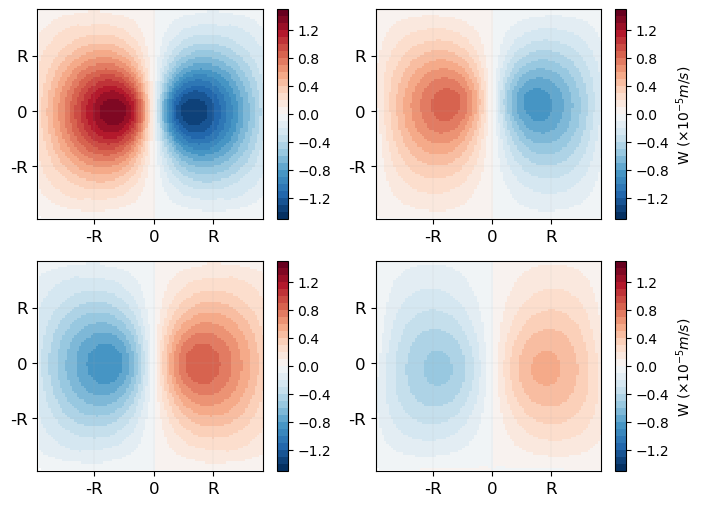

In [33]:
######## SCE和SAE x平均和正圆的计算结果
z=8
lev=np.linspace(-1.5,1.5,31)

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
(w_SCE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #SCE anomu/v + climb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ticks  = [-2,-1,0,1,2]
tlabels= ['-2R','-R','0','R','2R']
ax1 = plt.gca()  # 获取当前的轴对象
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tlabels)
ax1.set_yticklabels(tlabels)
ax1.set_xlim([-1.96,1.84])
ax1.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 2)
(w_SCE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #SCE anomu/v + hmeanb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax2 = plt.gca()  # 获取当前的轴对象
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tlabels)
ax2.set_yticklabels(tlabels)
ax2.set_xlim([-1.96,1.84])
ax2.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 3)
(w_SAE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #SAE anomu/v + climb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax3 = plt.gca()  # 获取当前的轴对象
ax3.set_xticks(ticks)
ax3.set_yticks(ticks)
ax3.set_xticklabels(tlabels)
ax3.set_yticklabels(tlabels)
ax3.set_xlim([-1.96,1.84])
ax3.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 4)
(w_SAE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #SAE anomu/v + hmeanb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax4 = plt.gca()  # 获取当前的轴对象
ax4.set_xticks(ticks)
ax4.set_yticks(ticks)
ax4.set_xticklabels(tlabels)
ax4.set_yticklabels(tlabels)
ax4.set_xlim([-1.96,1.84])
ax4.set_ylim([-1.96,1.84])


# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig9.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=300)
# plt.close()

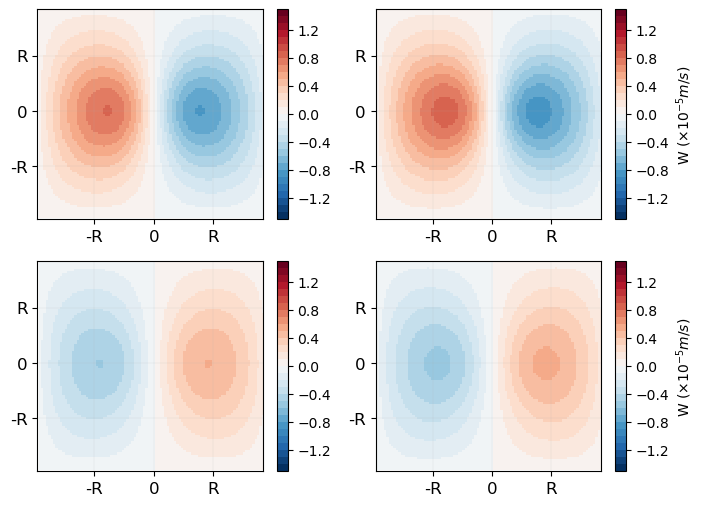

In [40]:
######## SCE和SAE只考虑beta的结果
z=8
lev=np.linspace(-1.5,1.5,31)

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
(w_SCE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#SCE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ticks  = [-2,-1,0,1,2]
tlabels= ['-2R','-R','0','R','2R']
ax1 = plt.gca()  # 获取当前的轴对象
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tlabels)
ax1.set_yticklabels(tlabels)
ax1.set_xlim([-1.96,1.84])
ax1.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 2)
(w_SCE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#SCE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax2 = plt.gca()  # 获取当前的轴对象
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tlabels)
ax2.set_yticklabels(tlabels)
ax2.set_xlim([-1.96,1.84])
ax2.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 3)
(w_SAE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#SAE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax3 = plt.gca()  # 获取当前的轴对象
ax3.set_xticks(ticks)
ax3.set_yticks(ticks)
ax3.set_xticklabels(tlabels)
ax3.set_yticklabels(tlabels)
ax3.set_xlim([-1.96,1.84])
ax3.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 4)
(w_SAE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#SAE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax4 = plt.gca()  # 获取当前的轴对象
ax4.set_xticks(ticks)
ax4.set_yticks(ticks)
ax4.set_xticklabels(tlabels)
ax4.set_yticklabels(tlabels)
ax4.set_xlim([-1.96,1.84])
ax4.set_ylim([-1.96,1.84])


# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig11.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=300)
# plt.close()

#### 6.1.1检查具体各项

In [ ]:
# SCE 的 ∂u/∂x, ∂v/∂x, ∂u/∂y, ∂v/∂y
z=8 #z:8=400m

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
SCE_anomux[z,2:98,2:98].plot(cmap='RdBu_r', vmax=1.5e-6, vmin=-1.5e-6)
plt.title('SCE anom ∂u/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
SCE_anomvx[z,2:98,2:98].plot(cmap='RdBu_r', vmax=1.5e-6, vmin=-1.5e-6)
plt.title('SCE anom ∂v/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
SCE_anomuy[z,2:98,2:98].plot(cmap='RdBu_r', vmax=1.5e-6, vmin=-1.5e-6)
plt.title('SCE anom ∂u/∂y')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
SCE_anomvy[z,2:98,2:98].plot(cmap='RdBu_r', vmax=1.5e-6, vmin=-1.5e-6)
plt.title('SCE anom ∂v/∂y')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

In [ ]:
# SCE: climb_new的∂b/∂x,∂b/∂y 以及 制作的涡旋的new∂b/∂x,∂b/∂y
z=8 #z:8=400m

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
SCE_climbx[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('SCE clim ∂b/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3) #放在四宫格的第3格
SCE_climby[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('SCE clim ∂b/∂y')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2) #放在四宫格的第2格
SCE_hmeanbx[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('SCE eddy ∂b/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4) #放在四宫格的第4格
SCE_hmeanby[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('SCE eddy ∂b/∂y')
plt.xlabel('')
plt.ylabel('')

In [ ]:
SCE_qx1 = SCE_anomux*SCE_hmeanbx
SCE_qx2 = SCE_anomvx*SCE_hmeanby
SCE_qx=SCE_qx1+SCE_qx2

SCE_qy1 = SCE_anomuy*SCE_hmeanbx
SCE_qy2 = SCE_anomvy*SCE_hmeanby
SCE_qy=SCE_qy1+SCE_qy2

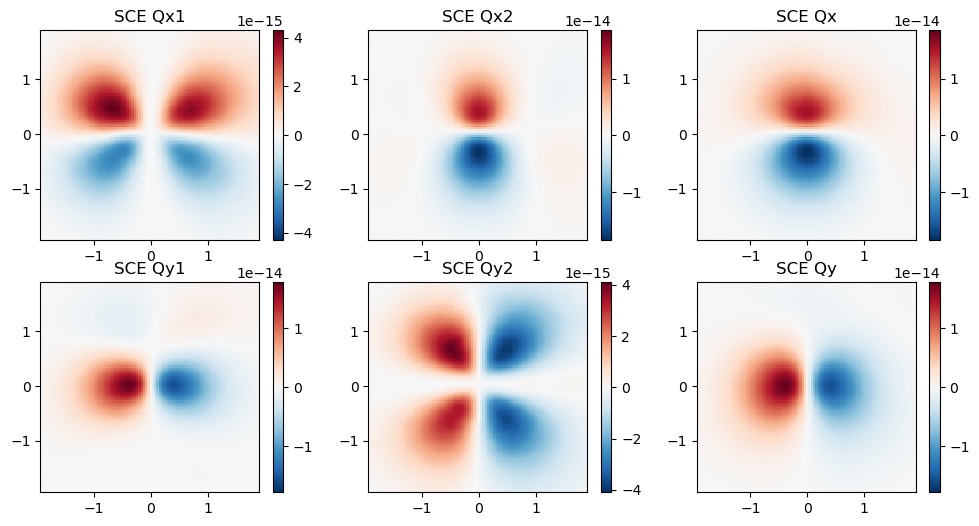

In [16]:
# SCE
z=8 #z:8=400m

fig = plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
SCE_qx1[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qx1')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 2)
SCE_qx2[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qx2')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 3)
SCE_qx[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qx')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 4)
SCE_qy1[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qy1')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 5)
SCE_qy2[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qy2')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 6)
SCE_qy[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qy')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

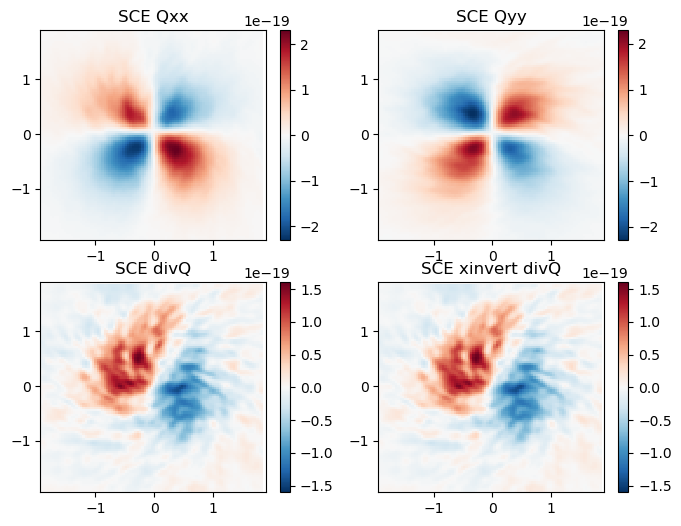

In [17]:
SCE_qxx, SCE_qxy = fd.grad(SCE_qx, ['X', 'Y'])
SCE_qyx, SCE_qyy = fd.grad(SCE_qy, ['X', 'Y'])
div_SCEQ = SCE_qxx+SCE_qyy

# SCE
z=8 #z:8=400m

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
SCE_qxx[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qxx')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
SCE_qyy[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE Qyy')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(div_SCEQ[z,2:98,2:98]*(-2)).plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE divQ')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
FQvec_SCEhmeanb[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('SCE xinvert divQ')
plt.xlabel('')
plt.ylabel('')

# plt.subplot(3, 3, 5)
# SCE_qy2[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
# plt.title('SCE Qy2')
# plt.xlabel('')
# plt.ylabel('')

# plt.subplot(3, 3, 6)
# SCE_qy[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
# plt.title('SCE Qy')
# plt.xlabel('')
# plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

### 6.2 extension dipole

In [41]:
from xinvert import FiniteDiff
fd = FiniteDiff({'X':'XC', 'Y':'YC', 'Z':'Z'},
                BCs={'X':('extend','extend'),
                     'Y':('extend','extend'),
                     'Z':('extend','extend')}, fill=0, coords='lat-lon')

In [42]:
#########  frt双核  ##########
ECE_1yt = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yt.nc').THETA
ECE_1ye = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_1ye.nc').ETAN
ECE_climt = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_climt.nc').THETA #ECE的climt，和ECE_anomt一起计算无水平梯度的涡旋背景密度
ECE_clime = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_clime.nc').ETAN
ECE_anomt = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_ta.nc').THETA
ECE_anome = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_ea.nc').ETAN
ECE_anomu = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_ua.nc').UVEL
ECE_anomv = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_va.nc').VVEL

EAE_1yt = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yt.nc').THETA
EAE_1ye = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_1ye.nc').ETAN
EAE_climt = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_climt.nc').THETA #EAE的climt，和EAE_anomt一起计算无水平梯度的涡旋背景密度
EAE_clime = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_clime.nc').ETAN
EAE_anomt = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_ta.nc').THETA
EAE_anome = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_ea.nc').ETAN
EAE_anomu = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_ua.nc').UVEL
EAE_anomv = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_va.nc').VVEL

# 修改ECE坐标
xnew_coord = np.linspace(15, 19, 101)#生成新的坐标值 (替换原有坐标)
ynew_coord = np.linspace(30, 34, 101)#生成新的坐标值 (替换原有坐标)
lev=np.arange(-5,-1055,-50)
ECE_1yt   = ECE_1yt.interp(Z=lev)
ECE_climt = ECE_climt.interp(Z=lev)
ECE_anomt = ECE_anomt.interp(Z=lev)
ECE_anomu = ECE_anomu.interp(Z=lev)
ECE_anomv = ECE_anomv.interp(Z=lev)
ECE_anomu=ECE_anomu.rename({'XG': 'XC'})
ECE_anomv=ECE_anomv.rename({'YG': 'YC'})
ECE_1yt = ECE_1yt.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_1ye = ECE_1ye.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_climt = ECE_climt.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_clime = ECE_clime.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_anomt = ECE_anomt.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_anome = ECE_anome.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_anomu = ECE_anomu.assign_coords(YC=ynew_coord, XC=xnew_coord)
ECE_anomv = ECE_anomv.assign_coords(YC=ynew_coord, XC=xnew_coord)

# 修改EAE坐标
EAE_1yt   = EAE_1yt.interp(Z=lev)
EAE_climt = EAE_climt.interp(Z=lev)
EAE_anomt = EAE_anomt.interp(Z=lev)
EAE_anomu = EAE_anomu.interp(Z=lev)
EAE_anomv = EAE_anomv.interp(Z=lev)
EAE_anomu=EAE_anomu.rename({'XG': 'XC'})
EAE_anomv=EAE_anomv.rename({'YG': 'YC'})
EAE_1yt = EAE_1yt.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_1ye = EAE_1ye.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_climt = EAE_climt.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_clime = EAE_clime.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_anomt = EAE_anomt.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_anome = EAE_anome.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_anomu = EAE_anomu.assign_coords(YC=ynew_coord, XC=xnew_coord)
EAE_anomv = EAE_anomv.assign_coords(YC=ynew_coord, XC=xnew_coord)

In [43]:
%%time
g = 9.81
rho0 = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4 # degrees^-1
def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + rho0
    return rho

ECE_climrho= linear_rho(35, ECE_climt, sref, tref)
EAE_climrho= linear_rho(35, EAE_climt, sref, tref)
# ECE_anomrho= linear_rho(35, ECE_anomt, sref, tref)
# EAE_anomrho= linear_rho(35, EAE_anomt, sref, tref)
ECE_1yrho= linear_rho(35, ECE_1yt, sref, tref)
EAE_1yrho= linear_rho(35, EAE_1yt, sref, tref)
ECE_anomrho= ECE_1yrho-ECE_climrho
EAE_anomrho= EAE_1yrho-EAE_climrho

# g = 9.81  # unit：m/s^2
# rho0 = 999.8  # 海水的平均密度，模式输出rhoRef为999.8，unit：kg/m^3
# sref = 35 # 绝对盐度为35, unit: g/kg
# h = xr.DataArray(-lev, dims=['Z'], coords={'Z':lev}).broadcast_like(ECE_climt)  # 自动扩展到相同维度
# ### ECE
# ECE_climpref = rho0 * g * (h + ECE_clime) # 计算静力近似的压力场 pref 以便进一步计算rho,pref只与垂直维度Z相关
# ECE_climCT = gsw.CT_from_pt(sref, ECE_climt) # 由位温计算保守温度CT（Conservative Temperature）
# ECE_climrho= gsw.rho(sref,ECE_climCT,ECE_climpref/1e4) # p_ref/1e4：帕转换为分巴, unit:dbar. (absolute pressure minus 10.1325 dbar)
# ECE_anompref = rho0 * g * (h + ECE_anome)
# ECE_anomCT = gsw.CT_from_pt(sref, ECE_anomt)
# ECE_anomrho= gsw.rho(sref,ECE_anomCT,ECE_anompref/1e4)
# ### EAE
# EAE_climpref = rho0 * g * (h + EAE_clime)
# EAE_climCT = gsw.CT_from_pt(sref, EAE_climt)
# EAE_climrho= gsw.rho(sref,EAE_climCT,EAE_climpref/1e4)
# EAE_anompref = rho0 * g * (h + EAE_anome)
# EAE_anomCT = gsw.CT_from_pt(sref, EAE_anomt)
# EAE_anomrho= gsw.rho(sref,EAE_anomCT,EAE_anompref/1e4)

ECE_hmean = ECE_climrho.mean(dim=['YC', 'XC']) + ECE_anomrho
EAE_hmean = EAE_climrho.mean(dim=['YC', 'XC']) + EAE_anomrho


CPU times: user 27.5 ms, sys: 719 µs, total: 28.2 ms
Wall time: 26.4 ms


In [44]:
#################################################
########## 把ECE和EAE的hmean密度做成正圆 ##########
#################################################

######## 相关参数和函数 ########
YC=np.linspace(-2, 2, 101) #笛卡尔坐标下原始坐标
XC=np.linspace(-2, 2, 101)
new_YC=np.linspace(-2.84, 2.84, 143) #笛卡尔坐标下扩展坐标（极坐标直径）
new_XC=np.linspace(-2.84, 2.84, 143)
X, Y  =np.meshgrid(new_XC, new_YC) #X为笛卡尔坐标下每个格点处的x索引，Y为笛卡尔坐标下每个格点处的y索引
sx,sy = int((len(new_XC)-1)/2-50) , int((len(new_YC)-1)/2-50)
ex,ey = int((len(new_XC)-1)/2+50+1) , int((len(new_YC)-1)/2+50+1)
# 极坐标参数
r = new_XC[int((len(new_XC)-1)/2):] #半径范围
th= np.linspace(0, 2*np.pi, 361) #角度范围
R, Th = np.meshgrid(r, th)
X_r,Y_r = R*np.cos(Th), R*np.sin(Th) #笛卡尔坐标系下的极坐标点的位置索引

######## 定义函数1（创造更大网格以包含外接圆）
def expand_grid(da, new_YC, new_XC): #！！！扩大后的网格需要：1.Z轴与原数组一致、2.每层以原数组的中心为中心、3.dx和dy与原数组一致
    bigdata = np.ones((len(da.Z),len(new_YC),len(new_XC)))*np.nan
    bigdata[:,sy:ey,sx:ex]=da
    big_da = xr.DataArray(data=bigdata, dims=da.dims,
                          coords={'Z': da.Z,'YC': new_YC,'XC': new_XC})
    return big_da
######## 定义函数2（插值到极坐标下的外接圆）
def interp2polar(big_da, X, Y, X_r, Y_r):
    cart_points = np.vstack([X.ravel(), Y.ravel()]).T  # 原始笛卡尔坐标点
    polar_points= np.vstack([X_r.ravel(), Y_r.ravel()]).T  # 目标极坐标对应的笛卡尔点
    # 对每个Z层分别插值
    Z_len = big_da.sizes['Z']
    th_len, r_len = X_r.shape
    interp_data = np.full((Z_len, th_len, r_len), np.nan)
    for i in range(Z_len):
        values = big_da.isel(Z=i).values.ravel()
        interp_layer = griddata(cart_points, values, polar_points, method='linear')
        interp_data[i, :, :] = interp_layer.reshape((th_len, r_len))
    # 构造新的xarray.DataArray输出
    interp_da = xr.DataArray(data=interp_data,dims=['Z', 'theta', 'r'],
                             coords={'Z': big_da.Z.values,'theta': th,'r': r})
    return interp_da
######## 定义函数3（平均成正圆）
def makecircle(interp_da): # mean to make circle
    mean_da = interp_da.mean(dim='theta', skipna=True) #在 theta 上求平均,xarray本身默认即跳过NaN
    circle_da = mean_da.broadcast_like(interp_da)  # 直接扩展广播回到原形状，成为正圆
    return circle_da
######## 定义函数4（正圆插值回原网格）
def interpback(circle_da, XC, YC, X_r, Y_r): # interp back
    points_polar = np.vstack([X_r.ravel(), Y_r.ravel()]).T  #(361*72, 2)
    XC_grid, YC_grid = np.meshgrid(XC, YC) #生成目标笛卡尔网格
    points_cart = np.vstack([XC_grid.ravel(), YC_grid.ravel()]).T  #(101*101, 2)
    interp_data = np.full((len(circle_da.Z), len(YC), len(XC)), np.nan) #初始化结果数组
    # 逐层插值
    for zz in range(len(circle_da.Z)):
        values = circle_da.isel(Z=zz).values.ravel() #提取当前层数据并展平
        # 执行插值（线性插值）
        interp_layer = griddata(points_polar,          # 原始点坐标
                                values,                # 原始点值
                                points_cart,           # 目标点坐标
                                method='linear',       # 插值方法
                                fill_value=np.nan)     # 填充值
        # 重塑并存储结果
        interp_data[zz] = interp_layer.reshape((len(YC), len(XC)))
    # 构建xarray对象
    back_da = xr.DataArray(data=interp_data,dims=['Z', 'YC', 'XC'],
                           coords={'Z': circle_da.Z,'YC': YC,'XC': XC})
    return back_da

######## 函数要求 ########
# da需是三维xarray数组, Z:21,YC:101,XC:101
# expand_grid扩大后的网格要求：1.Z轴与原数组一致、2.每层以原数组的中心为中心、3.dx和dy与原数组一致

In [45]:
%%time
ECE_anome_expand = ECE_anome.expand_dims(Z=[-5], axis=0)
EAE_anome_expand = EAE_anome.expand_dims(Z=[-5], axis=0)
ECE_anome3d = ECE_anome_expand.transpose('Z', 'YC', 'XC')
EAE_anome3d = EAE_anome_expand.transpose('Z', 'YC', 'XC')

big_ECE_hmean=expand_grid(ECE_hmean, new_YC, new_XC)
big_EAE_hmean=expand_grid(EAE_hmean, new_YC, new_XC)
big_ECE_anome=expand_grid(ECE_anome3d, new_YC, new_XC)
big_EAE_anome=expand_grid(EAE_anome3d, new_YC, new_XC)

interp_ECE_hmean=interp2polar(big_ECE_hmean, X, Y, X_r, Y_r)
interp_EAE_hmean=interp2polar(big_EAE_hmean, X, Y, X_r, Y_r)
interp_ECE_anome=interp2polar(big_ECE_anome, X, Y, X_r, Y_r)
interp_EAE_anome=interp2polar(big_EAE_anome, X, Y, X_r, Y_r)

circle_ECE_hmean=makecircle(interp_ECE_hmean)
circle_EAE_hmean=makecircle(interp_EAE_hmean)
circle_ECE_anome=makecircle(interp_ECE_anome)
circle_EAE_anome=makecircle(interp_EAE_anome)

back_ECE_hmean=interpback(circle_ECE_hmean, XC, YC, X_r, Y_r)
back_EAE_hmean=interpback(circle_EAE_hmean, XC, YC, X_r, Y_r)
back_ECE_anome=interpback(circle_ECE_anome, XC, YC, X_r, Y_r)
back_EAE_anome=interpback(circle_EAE_anome, XC, YC, X_r, Y_r)

#按照副热带区域修改经纬坐标
back_ECE_hmean = back_ECE_hmean.assign_coords(YC=ynew_coord, XC=xnew_coord)
back_EAE_hmean = back_EAE_hmean.assign_coords(YC=ynew_coord, XC=xnew_coord)
back_ECE_anome = back_ECE_anome.assign_coords(YC=ynew_coord, XC=xnew_coord)
back_EAE_anome = back_EAE_anome.assign_coords(YC=ynew_coord, XC=xnew_coord)

CPU times: user 44.2 s, sys: 22.9 s, total: 1min 7s
Wall time: 38.2 s


Text(0, 0.5, '')

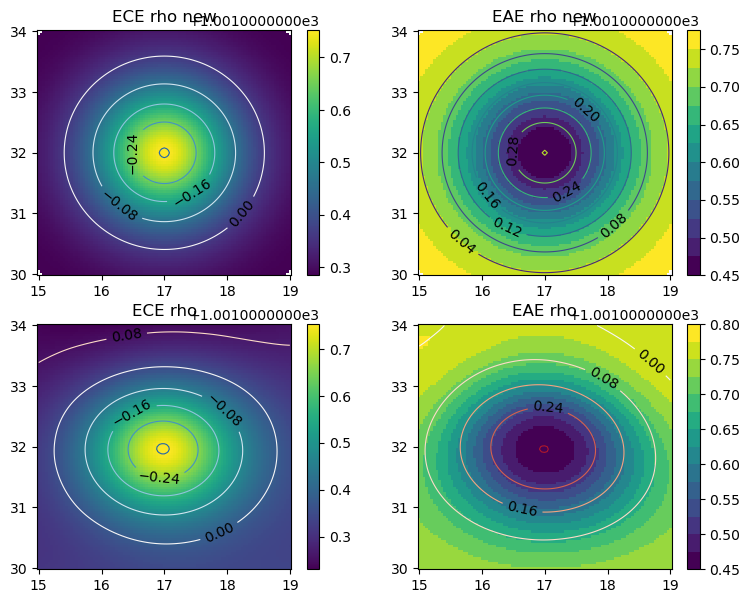

In [46]:
fig = plt.figure(figsize=(9, 7))
plt.subplot(2, 2, 1)
(back_ECE_hmean[8,]).plot(cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)levels=15, 
dd = (back_ECE_anome[0]).plot.contour(levels=10, linewidths=.8)
plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('ECE rho new')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(back_EAE_hmean[8,]).plot(levels=15, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
dd = (back_EAE_anome[0]).plot.contour(levels=10, linewidths=.8)
plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('EAE rho new')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(ECE_hmean[8,]).plot(cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)levels=15, 
dd = (ECE_anome).plot.contour(levels=10, linewidths=.8)
plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('ECE rho')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(EAE_hmean[8,]).plot(levels=15, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
dd = (EAE_anome).plot.contour(levels=10, linewidths=.8)
plt.clabel(dd, inline=10, fontsize=10, colors='k')
plt.title('EAE rho')
plt.xlabel('')
plt.ylabel('')

In [47]:
######## ρgdz计算每层压力p,然后积分求出实际p,进一步求地转uv ########
###求每层p
dz=50
ECE_dzpre=xr.zeros_like(back_ECE_hmean) #单层p
EAE_dzpre=xr.zeros_like(back_EAE_hmean)
# ECE_dzpre[0,:,:]=p0 #ECE第0层上表面p
# EAE_dzpre[0,:,:]=p0
ECE_dzpre[0,:,:]=back_ECE_hmean[0]*g*(-back_ECE_hmean.Z[0]+(dz/2)+back_ECE_anome[0]) #ECE第0层下表面单层p
EAE_dzpre[0,:,:]=back_EAE_hmean[0]*g*(-back_EAE_hmean.Z[0]+(dz/2)+back_EAE_anome[0])
for i in np.arange(1,20):
    ECE_dzpre[i,:,:]=back_ECE_hmean[i,:,:]*g*dz #第i层下表面处的单层p
    EAE_dzpre[i,:,:]=back_EAE_hmean[i,:,:]*g*dz

###积分求实际p
ECE_pre=xr.zeros_like(back_ECE_hmean) #单层p求和积分后的实际p
EAE_pre=xr.zeros_like(back_EAE_hmean)
ECE_pre[0,:,:]=back_ECE_hmean[0]*g*(-back_ECE_hmean.Z[0]+back_ECE_anome[0]) #ECE第0层p
EAE_pre[0,:,:]=back_EAE_hmean[0]*g*(-back_EAE_hmean.Z[0]+back_EAE_anome[0])
for i in np.arange(1,21):
    ECE_pre[i,:,:]=ECE_dzpre[:i,:,:].sum(dim='Z')+back_ECE_hmean[i]*g*(dz/2)
    EAE_pre[i,:,:]=EAE_dzpre[:i,:,:].sum(dim='Z')+back_EAE_hmean[i]*g*(dz/2)

In [48]:
###求地转流uv
# ECE_p=ECE_pre.assign_coords({'XC': np.linspace(19.5, 20.5, 101),'YC': np.linspace(19.5, 20.5, 101)})
# EAE_p=ECE_pre.assign_coords({'XC': np.linspace(19.5, 20.5, 101),'YC': np.linspace(19.5, 20.5, 101)})
# omg   = 2*math.pi/(86400) # unit: rad/s
# sub_f0= 2*omg*np.sin(np.deg2rad(20)) #以20°N为f0
# ECE_prex, ECE_prey = fd.grad(ECE_p, ['X', 'Y'])
# EAE_prex, EAE_prey = fd.grad(EAE_p, ['X', 'Y'])

omg   = 2*math.pi/(86400) # unit: rad/s
frt_f0= 2*omg*np.sin(np.deg2rad(15)) #以15°N为f0
ECE_prex, ECE_prey = fd.grad(ECE_pre, ['X', 'Y'])
EAE_prex, EAE_prey = fd.grad(EAE_pre, ['X', 'Y'])

ECE_anomug = -ECE_prey/(rho0*frt_f0)
ECE_anomvg = ECE_prex/(rho0*frt_f0)
EAE_anomug = -EAE_prey/(rho0*frt_f0)
EAE_anomvg = EAE_prex/(rho0*frt_f0)

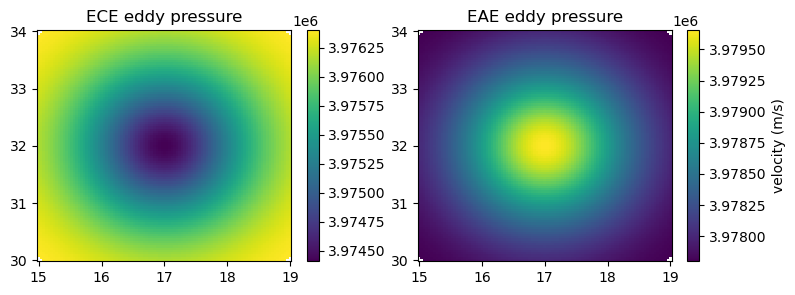

In [49]:
# ECE和EAE 压强pre(无NaN值)
z=8
lev=np.linspace(-0.12,0.12,25)
# lev=25
fig = plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
(ECE_pre[z,]).plot(cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)levels=lev, 
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE eddy pressure')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
(EAE_pre[z,]).plot(cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE eddy pressure')
plt.xlabel('')
plt.ylabel('')

savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

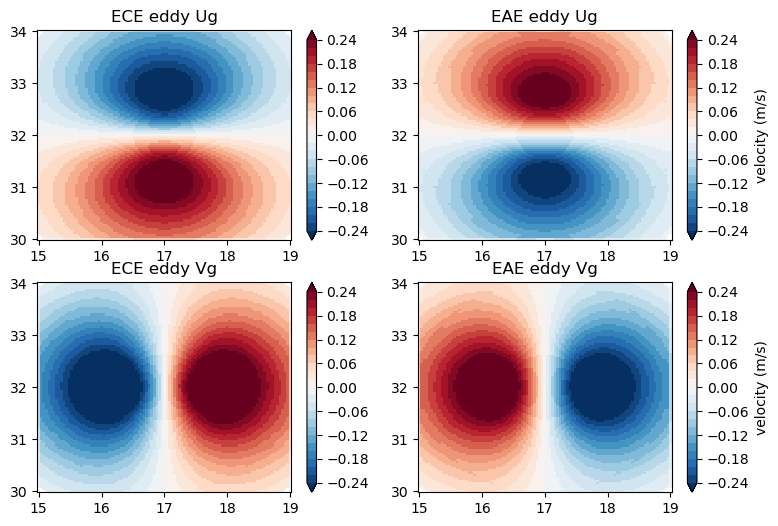

In [50]:
# ECE和EAE 地转流UV(无NaN值)
z=8
lev=np.linspace(-0.24,0.24,25)
# lev=25
fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
(ECE_anomug[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE eddy Ug')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(EAE_anomug[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE eddy Ug')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(ECE_anomvg[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE eddy Vg')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(EAE_anomvg[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE eddy Vg')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

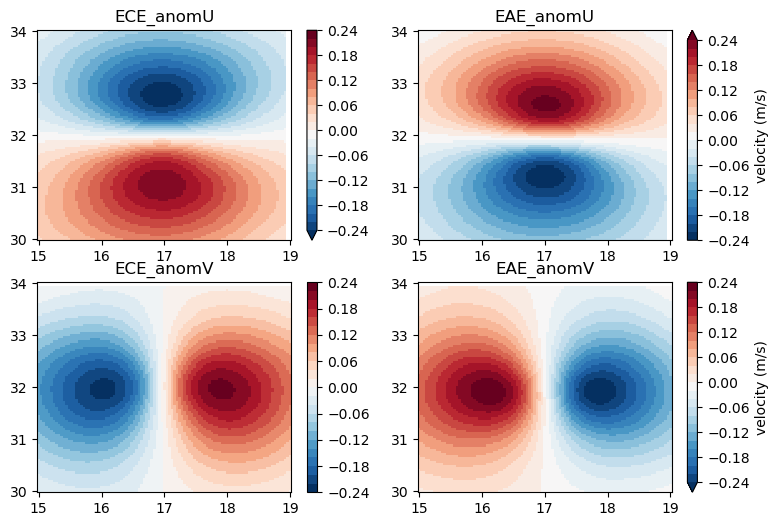

In [51]:
# ECE和EAE anomUV(有NaN值)
lev=np.linspace(-0.24,0.24,25)

z=8
fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
(ECE_anomu[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE_anomU')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(EAE_anomu[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE_anomU')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(ECE_anomv[z,]).plot(levels=lev, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE_anomV')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(EAE_anomv[z,]).plot(levels=lev, cbar_kwargs=dict(label='velocity (m/s)'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE_anomV')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

In [52]:
########## 把ECE和EAE的climb在x方向进行平均 ##########
ECE_mean_xc = ECE_climrho.mean(dim='XC') #在 XC 维度上求平均，得到形状 (21, 101)
EAE_mean_xc = EAE_climrho.mean(dim='XC')
ECE_climrho_new = ECE_mean_xc * xr.ones_like(ECE_climrho) #均值广播回原始维度 (21, 101, 101)
EAE_climrho_new = EAE_mean_xc * xr.ones_like(EAE_climrho)

Text(0, 0.5, '')

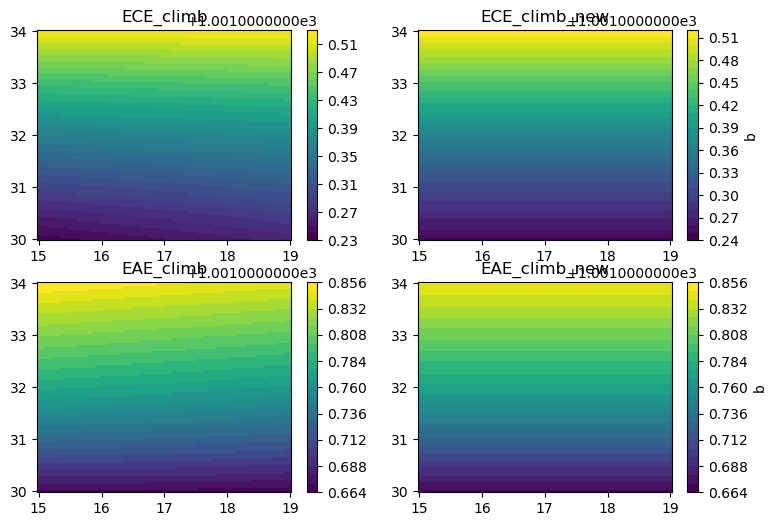

In [53]:
########## 检查climb_new的图像 ##########
z=8

fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 2, 1)
(ECE_climrho[z,]).plot(levels=30, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE_climb')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
(ECE_climrho_new[z,]).plot(levels=30, cbar_kwargs=dict(label='b'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('ECE_climb_new')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(EAE_climrho[z,]).plot(levels=30, cbar_kwargs=dict(label=r''), )#cmap='RdBu_r', levels=41)
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE_climb')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
(EAE_climrho_new[z,]).plot(levels=30, cbar_kwargs=dict(label='b'), )#cmap='RdBu_r', levels=41, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('EAE_climb_new')
plt.xlabel('')
plt.ylabel('')

In [54]:
# sigma = linear_rho(35, temp, sref, tref) - 1000 # sigma is " rho' "
ECE_climb = ECE_climrho_new * (-g/rho0)
EAE_climb = EAE_climrho_new * (-g/rho0)
ECE_hmeanb= back_ECE_hmean * (-g/rho0)
EAE_hmeanb= back_EAE_hmean * (-g/rho0)
# omg = 2*math.pi/(86400) # unit: rad/s
# f  = 2*omg*np.sin(np.deg2rad(dipole_t.YC))
ECE_climN2 = ECE_climb.mean(['YC','XC']).load().differentiate('Z').load()
EAE_climN2 = EAE_climb.mean(['YC','XC']).load().differentiate('Z').load()
ECE_hmeanN2= ECE_hmeanb.mean(['YC','XC']).load().differentiate('Z').load()
EAE_hmeanN2= EAE_hmeanb.mean(['YC','XC']).load().differentiate('Z').load()

In [55]:
%%time

ECE_anomux, ECE_anomuy = fd.grad(ECE_anomug, ['X', 'Y']) #改成了ugvg
ECE_anomvx, ECE_anomvy = fd.grad(ECE_anomvg, ['X', 'Y'])
EAE_anomux, EAE_anomuy = fd.grad(EAE_anomug, ['X', 'Y'])
EAE_anomvx, EAE_anomvy = fd.grad(EAE_anomvg, ['X', 'Y'])
############ Q-vector form：anomu/anomv和 climb_new ############
#####ECE
ECE_climbx, ECE_climby = fd.grad(ECE_climb, ['X', 'Y'])
Qx_ECEclimb = ECE_anomux*ECE_climbx + ECE_anomvx*ECE_climby
Qy_ECEclimb = ECE_anomuy*ECE_climbx + ECE_anomvy*ECE_climby
divQ_ECEclimb  = -2 * fd.divg((Qx_ECEclimb, Qy_ECEclimb), ['X', 'Y'])
FQvec_ECEclimb = xr.where(np.isfinite(divQ_ECEclimb), divQ_ECEclimb, np.nan).load()
#####EAE
EAE_climbx, EAE_climby = fd.grad(EAE_climb, ['X', 'Y'])
Qx_EAEclimb = EAE_anomux*EAE_climbx + EAE_anomvx*EAE_climby
Qy_EAEclimb = EAE_anomuy*EAE_climbx + EAE_anomvy*EAE_climby
divQ_EAEclimb  = -2 * fd.divg((Qx_EAEclimb, Qy_EAEclimb), ['X', 'Y'])
FQvec_EAEclimb = xr.where(np.isfinite(divQ_EAEclimb), divQ_EAEclimb, np.nan).load()
############ Q-vector form：anomu/anomv和 hmeanb_new ############
#####EAE
ECE_hmeanbx, ECE_hmeanby = fd.grad(ECE_hmeanb, ['X', 'Y'])
Qx_ECEhmeanb = ECE_anomux*ECE_hmeanbx + ECE_anomvx*ECE_hmeanby
Qy_ECEhmeanb = ECE_anomuy*ECE_hmeanbx + ECE_anomvy*ECE_hmeanby
divQ_ECEhmeanb  = -2 * fd.divg((Qx_ECEhmeanb, Qy_ECEhmeanb), ['X', 'Y'])
FQvec_ECEhmeanb = xr.where(np.isfinite(divQ_ECEhmeanb), divQ_ECEhmeanb, np.nan).load()
#####EAE
EAE_hmeanbx, EAE_hmeanby = fd.grad(EAE_hmeanb, ['X', 'Y'])
Qx_EAEhmeanb = EAE_anomux*EAE_hmeanbx + EAE_anomvx*EAE_hmeanby
Qy_EAEhmeanb = EAE_anomuy*EAE_hmeanbx + EAE_anomvy*EAE_hmeanby
divQ_EAEhmeanb  = -2 * fd.divg((Qx_EAEhmeanb, Qy_EAEhmeanb), ['X', 'Y'])
FQvec_EAEhmeanb = xr.where(np.isfinite(divQ_EAEhmeanb), divQ_EAEhmeanb, np.nan).load()

CPU times: user 1.07 s, sys: 135 ms, total: 1.21 s
Wall time: 929 ms


In [56]:
############ calculate beta effect term ############
#假设合成后的矩形范围位于30-34°N
omg   = 2*math.pi/(86400) # unit: rad/s
frt_f = 2*omg*np.sin(np.deg2rad(ECE_anomvg.YC))
frt_f_3d = frt_f.broadcast_like(ECE_anomvg)# 将frt_f广播到三维空间
beta=fd.grad(frt_f_3d, ['Y']) #beta.values

######ECE
ECE_vgz=fd.grad(ECE_anomvg, ['Z'])
ECE_betaterm = frt_f_3d * beta * ECE_vgz
######EAE
EAE_vgz=fd.grad(EAE_anomvg, ['Z'])
EAE_betaterm = frt_f_3d * beta * EAE_vgz

In [62]:
%%time
from xinvert import invert_omega
iParams = {
    'BCs'      : ['fixed', 'fixed', 'extend'],
    'mxLoop'   : 500,
    'tolerance': 1e-9,}

mParams = {'N2': ECE_climN2} #ECE的'clim'N2
w_ECE_clim_new = invert_omega(ECE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
mParams = {'N2': EAE_climN2} #EAE的'clim'N2
w_EAE_clim_new = invert_omega(EAE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

mParams = {'N2': ECE_hmeanN2} #ECE的'horizontal mean'N2
w_ECE_hmean_new = invert_omega(ECE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
mParams = {'N2': EAE_hmeanN2} #EAE的'horizontal mean'N2
w_EAE_hmean_new = invert_omega(EAE_betaterm, dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

# mParams = {'N2': ECE_climN2} #ECE的'clim'N2
# w_ECE_clim_new = invert_omega((FQvec_ECEclimb+ECE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
# mParams = {'N2': EAE_climN2} #EAE的'clim'N2
# w_EAE_clim_new = invert_omega((FQvec_EAEclimb+EAE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

# mParams = {'N2': ECE_hmeanN2} #ECE的'horizontal mean'N2
# w_ECE_hmean_new = invert_omega((FQvec_ECEhmeanb+ECE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()
# mParams = {'N2': EAE_hmeanN2} #EAE的'horizontal mean'N2
# w_EAE_hmean_new = invert_omega((FQvec_EAEhmeanb+EAE_betaterm), dims=['Z','YC','XC'], iParams=iParams, mParams=mParams).load()

{} loops  148 and tolerance is 8.656130e-10
{} loops  118 and tolerance is 9.810482e-10
{} loops  141 and tolerance is 9.910245e-10
{} loops  123 and tolerance is 8.603283e-10
CPU times: user 2.2 s, sys: 158 ms, total: 2.35 s
Wall time: 2.13 s


In [63]:
# 将假设经纬度重新设置为 归一化的半径比例
w_ECE_clim_new = w_ECE_clim_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))
w_ECE_hmean_new= w_ECE_hmean_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))
w_EAE_clim_new = w_EAE_clim_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))
w_EAE_hmean_new= w_EAE_hmean_new.assign_coords(YC=np.linspace(-2,2,101), XC=np.linspace(-2,2,101))

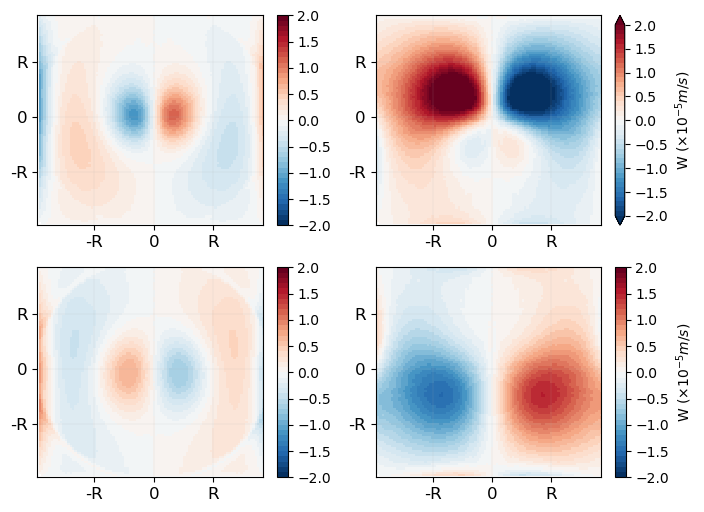

In [60]:
######## ECE和EAE x平均和正圆的计算结果
z=8
lev=np.linspace(-2.,2.,41)

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
(w_ECE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #ECE anomu/v + climb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ticks  = [-2,-1,0,1,2]
tlabels= ['-2R','-R','0','R','2R']
ax1 = plt.gca()  # 获取当前的轴对象
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tlabels)
ax1.set_yticklabels(tlabels)
ax1.set_xlim([-1.96,1.84])
ax1.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 2)
(w_ECE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #ECE anomu/v + hmeanb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax2 = plt.gca()  # 获取当前的轴对象
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tlabels)
ax2.set_yticklabels(tlabels)
ax2.set_xlim([-1.96,1.84])
ax2.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 3)
(w_EAE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #EAE anomu/v + climb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax3 = plt.gca()  # 获取当前的轴对象
ax3.set_xticks(ticks)
ax3.set_yticks(ticks)
ax3.set_xticklabels(tlabels)
ax3.set_yticklabels(tlabels)
ax3.set_xlim([-1.96,1.84])
ax3.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 4)
(w_EAE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500') #EAE anomu/v + hmeanb_new
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax4 = plt.gca()  # 获取当前的轴对象
ax4.set_xticks(ticks)
ax4.set_yticks(ticks)
ax4.set_xticklabels(tlabels)
ax4.set_yticklabels(tlabels)
ax4.set_xlim([-1.96,1.84])
ax4.set_ylim([-1.96,1.84])


# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig10.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=300)
# plt.close()

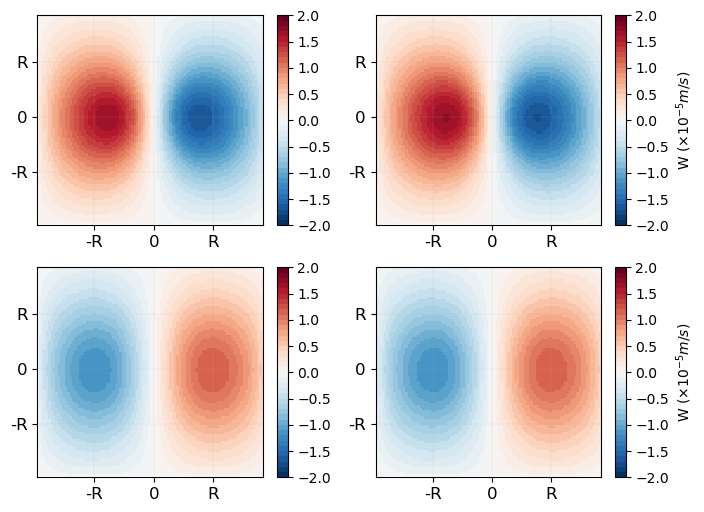

In [64]:
######## ECE和EAE只考虑beta的结果
z=8
lev=np.linspace(-2.,2.,41)

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
(w_ECE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#ECE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ticks  = [-2,-1,0,1,2]
tlabels= ['-2R','-R','0','R','2R']
ax1 = plt.gca()  # 获取当前的轴对象
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tlabels)
ax1.set_yticklabels(tlabels)
ax1.set_xlim([-1.96,1.84])
ax1.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 2)
(w_ECE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#ECE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax2 = plt.gca()  # 获取当前的轴对象
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tlabels)
ax2.set_yticklabels(tlabels)
ax2.set_xlim([-1.96,1.84])
ax2.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 3)
(w_EAE_clim_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r''))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#EAE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax3 = plt.gca()  # 获取当前的轴对象
ax3.set_xticks(ticks)
ax3.set_yticks(ticks)
ax3.set_xticklabels(tlabels)
ax3.set_yticklabels(tlabels)
ax3.set_xlim([-1.96,1.84])
ax3.set_ylim([-1.96,1.84])

plt.subplot(2, 2, 4)
(w_EAE_hmean_new[z,2:98,2:98]*100000).plot(cmap='RdBu_r', levels=lev, cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
# dd = (np.mean(w_xinvert[:,2:98,2:98],0)*100000).plot.contour(cmap='jet', levels=16, linewidths=.8)
# plt.clabel(dd, inline=10, fontsize=12, colors='k')
plt.title('',fontsize=10,fontweight='500')#EAE of fβ∂vg/∂z
plt.grid(linewidth='0.1')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('')
plt.ylabel('')
ax4 = plt.gca()  # 获取当前的轴对象
ax4.set_xticks(ticks)
ax4.set_yticks(ticks)
ax4.set_xticklabels(tlabels)
ax4.set_yticklabels(tlabels)
ax4.set_xlim([-1.96,1.84])
ax4.set_ylim([-1.96,1.84])


# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig12.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=300)
# plt.close()

#### 6.2.1 检查具体各项

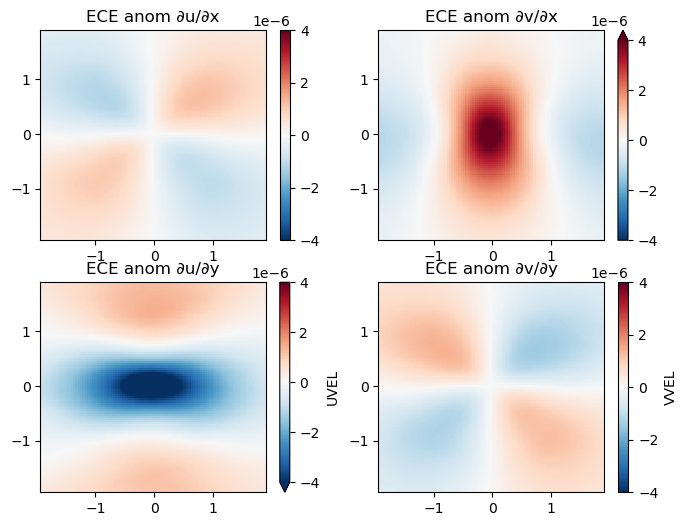

In [ ]:
# ECE 的 ∂u/∂x, ∂v/∂x, ∂u/∂y, ∂v/∂y
z=8 #z:8=400m

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
ECE_anomux[z,2:98,2:98].plot(cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE anom ∂u/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
ECE_anomvx[z,2:98,2:98].plot(cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE anom ∂v/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
ECE_anomuy[z,2:98,2:98].plot(cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE anom ∂u/∂y')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
ECE_anomvy[z,2:98,2:98].plot(cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE anom ∂v/∂y')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

Text(0, 0.5, '')

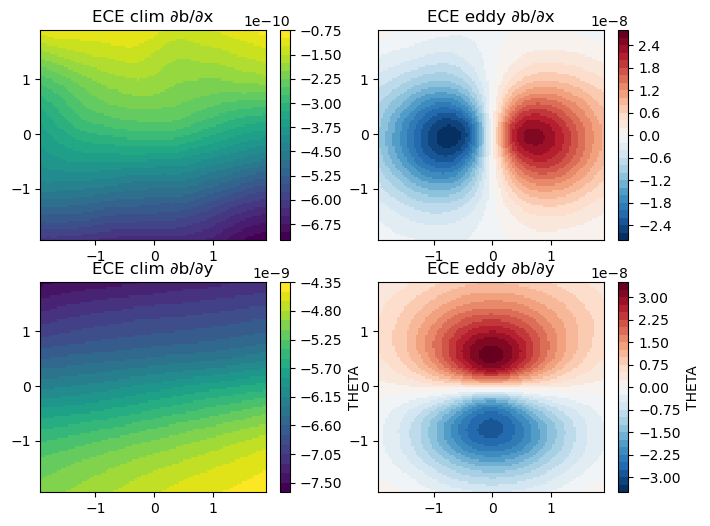

In [ ]:
# ECE: clim的∂b/∂x,∂b/∂y 以及 制作的涡旋∂b/∂x,∂b/∂y
z=8 #z:8=400m

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
ECE_climbx[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('ECE clim ∂b/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3) #放在四宫格的第3格
ECE_climby[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('ECE clim ∂b/∂y')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2) #放在四宫格的第2格
ECE_hmeanbx[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('ECE eddy ∂b/∂x')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4) #放在四宫格的第4格
ECE_hmeanby[z,2:98,2:98].plot(levels=30)#cmap='RdBu_r', vmax=3e-9, vmin=-3e-9)
plt.title('ECE eddy ∂b/∂y')
plt.xlabel('')
plt.ylabel('')

In [ ]:
ECE_qx1 = ECE_anomux*ECE_hmeanbx
ECE_qx2 = ECE_anomvx*ECE_hmeanby
ECE_qx=ECE_qx1+ECE_qx2

ECE_qy1 = ECE_anomuy*ECE_hmeanbx
ECE_qy2 = ECE_anomvy*ECE_hmeanby
ECE_qy=ECE_qy1+ECE_qy2

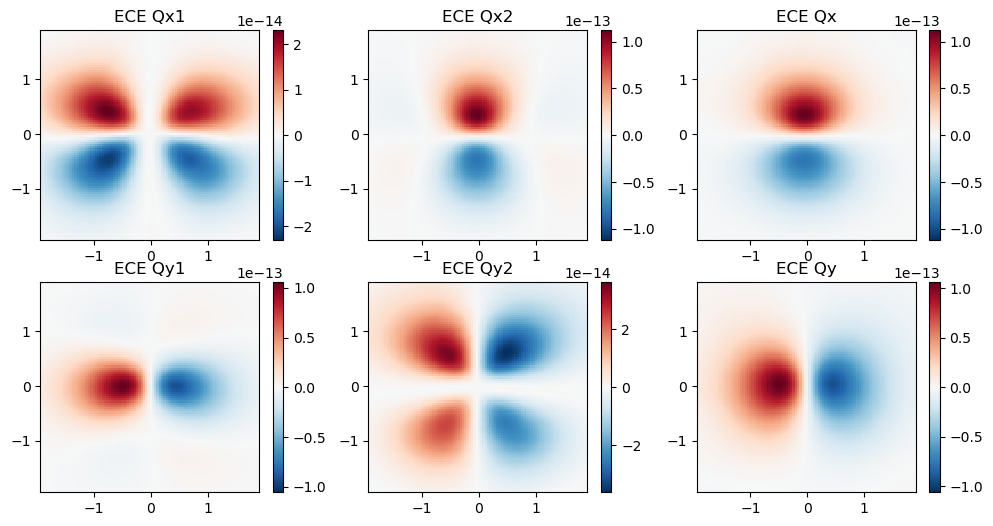

In [ ]:
# ECE 的 ∂u/∂x, ∂v/∂x, ∂u/∂y, ∂v/∂y
z=8 #z:8=400m

fig = plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
ECE_qx1[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qx1')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 2)
ECE_qx2[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qx2')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 3)
ECE_qx[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qx')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 4)
ECE_qy1[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qy1')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 5)
ECE_qy2[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qy2')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 6)
ECE_qy[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qy')
plt.xlabel('')
plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)

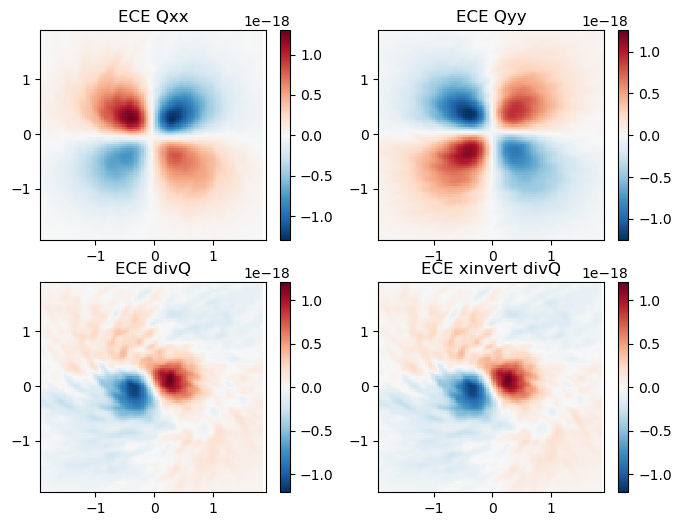

In [ ]:
ECE_qxx, ECE_qxy = fd.grad(ECE_qx, ['X', 'Y'])
ECE_qyx, ECE_qyy = fd.grad(ECE_qy, ['X', 'Y'])
div_ECEQ = ECE_qxx+ECE_qyy

# ECE
z=8 #z:8=400m

fig = plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
ECE_qxx[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qxx')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
ECE_qyy[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE Qyy')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
(div_ECEQ[z,2:98,2:98]*(-2)).plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE divQ')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
FQvec_ECEhmeanb[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
plt.title('ECE xinvert divQ')
plt.xlabel('')
plt.ylabel('')

# plt.subplot(3, 3, 5)
# ECE_qy2[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
# plt.title('ECE Qy2')
# plt.xlabel('')
# plt.ylabel('')

# plt.subplot(3, 3, 6)
# ECE_qy[z,2:98,2:98].plot()#cmap='RdBu_r', vmax=4e-6, vmin=-4e-6)
# plt.title('ECE Qy')
# plt.xlabel('')
# plt.ylabel('')
savename = ''
# plt.savefig('/data/home/zhangrd/Pictures/compo_1y_wa+ta+e/'+savename,dpi=150)